# The Sound of Success Through the Years
## Music Clustering Analysis Using Million Song Dataset

**Research Question**: How have the audio characteristics of successful songs evolved over time, and can we identify distinct 'eras' of popular music based on clustering analysis of audio features?

**Dataset**: Million Song Dataset (10,000 song subset)

**Approach**: K-means, Hierarchical Clustering, and DBSCAN combined with dimensionality reduction (PCA, t-SNE)

---

## Section 1: Data Loading & Problem Statement

### 1.1 Import Libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import h5py
import os
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import f_oneway, ttest_ind

# Settings
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


### 1.2 Load Million Song Dataset Subset

The Million Song Dataset contains audio features extracted by Echo Nest. Each song is stored in a separate HDF5 file organized by artist ID.

In [2]:
def extract_song_data(h5_file_path):
    """
    Extract relevant features from a single HDF5 file.
    
    Parameters:
    -----------
    h5_file_path : str
        Path to the HDF5 file
    
    Returns:
    --------
    dict : Dictionary containing extracted features
    """
    try:
        with h5py.File(h5_file_path, 'r') as h5:
            # Audio analysis features (using named fields)
            analysis = h5['analysis']['songs'][0]
            tempo = float(analysis['tempo'])
            loudness = float(analysis['loudness'])
            duration = float(analysis['duration'])
            key = int(analysis['key'])
            mode = int(analysis['mode'])
            time_signature = int(analysis['time_signature'])
            
            # Timbre features (12-dimensional)
            segments_timbre = h5['analysis']['segments_timbre'][:]
            if len(segments_timbre) > 0:
                timbre = np.mean(segments_timbre, axis=0)  # Average over all segments
            else:
                timbre = np.zeros(12)
            
            # Metadata (using named fields)
            metadata = h5['metadata']['songs'][0]
            year = int(h5['musicbrainz']['songs'][0]['year'])
            artist_name = metadata['artist_name'].decode('utf-8')
            song_title = metadata['title'].decode('utf-8')
            
            # Success metrics
            song_hotttnesss = float(metadata['song_hotttnesss'])
            artist_familiarity = float(metadata['artist_familiarity'])
            artist_hotttnesss = float(metadata['artist_hotttnesss'])
            
            # Create dictionary
            song_data = {
                'tempo': tempo,
                'loudness': loudness,
                'duration': duration,
                'key': key,
                'mode': mode,
                'time_signature': time_signature,
                'year': year if year > 0 else np.nan,
                'artist_name': artist_name,
                'song_title': song_title,
                'song_hotttnesss': song_hotttnesss if song_hotttnesss > 0 else np.nan,
                'artist_familiarity': artist_familiarity if artist_familiarity > 0 else np.nan,
                'artist_hotttnesss': artist_hotttnesss if artist_hotttnesss > 0 else np.nan
            }
            
            # Add timbre features
            for i in range(12):
                song_data[f'timbre_{i+1}'] = timbre[i]
            
            return song_data
    
    except Exception as e:
        print(f"Error processing {h5_file_path}: {str(e)}")
        return None

# Path to dataset
dataset_path = Path("MillionSongSubset")

# Collect all .h5 file paths
print("Collecting HDF5 file paths...")
h5_files = list(dataset_path.rglob("*.h5"))
print(f"Found {len(h5_files)} HDF5 files")

# Extract data from all files
print("\nExtracting data from HDF5 files... (this may take 1-2 minutes)")
songs_data = []

for i, h5_file in enumerate(h5_files):
    if i % 1000 == 0:
        print(f"Processed {i}/{len(h5_files)} files...")
    
    song_data = extract_song_data(h5_file)
    if song_data is not None:
        songs_data.append(song_data)

# Create DataFrame
df = pd.DataFrame(songs_data)

print(f"\nDataset loaded successfully!")
print(f"Total songs: {len(df)}")
print(f"Total features: {len(df.columns)}")

Found 10000 HDF5 files

Extracting data from HDF5 files... (this may take 1-2 minutes)
Processed 0/10000 files...
Processed 1000/10000 files...
Processed 2000/10000 files...
Processed 3000/10000 files...
Processed 4000/10000 files...
Processed 5000/10000 files...
Processed 6000/10000 files...
Processed 7000/10000 files...
Processed 8000/10000 files...
Processed 9000/10000 files...

Dataset loaded successfully!
Total songs: 10000
Total features: 24


### 1.3 Dataset Provenance and Problem Statement

**Dataset Information**:
- **Name**: Million Song Dataset (MSD) - 10,000 song subset
- **Source**: Echo Nest (acquired by Spotify) / Columbia University
- **Collection**: Automated audio analysis from 2011
- **Time Period**: Songs spanning approximately 1920s-2010
- **License**: Research and educational use

**Success Metric**:
- `song_hotttnesss`: 0-1 popularity score from Echo Nest (frozen at 2011)
- Based on: web mentions, social media, streaming/listening data, chart performance

**Research Questions**:
1. What audio features distinguish successful songs across different decades?
2. Can we identify natural clusters representing musical "eras" or styles?
3. How do success metrics correlate with different audio feature clusters?
4. Has the "sound of success" converged or diverged over time?
5. Are there "breakthrough" songs that don't fit established patterns?

**Unsupervised Learning Approaches**:
- **K-means**: Partition songs into k distinct clusters
- **Hierarchical Clustering**: Build dendrogram to understand relationships
- **DBSCAN**: Density-based clustering to identify core patterns and outliers
- **PCA & t-SNE**: Dimensionality reduction for visualization

**Limitations**:
- Audio features only (no lyrics or cultural context)
- Success metric frozen at 2011
- Survival bias: may over-represent successful songs
- Technology confounding: recording technology changed over time

**Dataset Size**:
- Original subset: 10,000 songs
- After filtering (valid year 1950-2010, non-missing success metric): ~2,700 songs (27%)
- The 73% data loss reflects inherent missing data in the Million Song Dataset
- While modest, N~2,700 remains sufficient for exploratory clustering analysis

---
## Section 2: Exploratory Data Analysis

### 2.1 Data Inspection

In [3]:
# Display basic information
print("Dataset Shape:", df.shape)
print("\nMemory Usage:")
print(f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
df.head()

Dataset Shape: (10000, 24)

Memory Usage:
3.09 MB

First few rows:


tempo  loudness   duration  key  mode  time_signature    year  \
0  124.059    -9.636  148.74077    0     1               4  2008.0   
1   80.084   -11.061  252.99546    1     0               4  2004.0   
2   54.874   -24.140   78.02730    3     1               4     NaN   
3   77.150    -5.795  163.63057    7     1               3  2007.0   
4  120.382   -16.477  199.99302   10     1               4     NaN   

              artist_name                             song_title  \
0                 Raphaël         Je Sais Que La Terre Est Plate   
1           Julie Zenatti                              On Efface   
2   The Baltimore Consort                        Howells Delight   
3            I Hate Sally                          Martha Served   
4  Orlando Pops Orchestra  Zip-A-Dee-Doo-Dah (Song of the South)   

   song_hotttnesss  ...   timbre_3   timbre_4   timbre_5   timbre_6  \
0         0.547953  ... -13.431835  -8.424728  -8.452409 -13.410788   
1         0.475638  ...  54.445222   0.692180  25.061545 -12.366970   
2              NaN  ...  26.853805 -13.406868 -13.894580  -2.407649   
3              NaN  ...  36.705763  -1.993846 -21.519207 -27.862433   
4              NaN  ...  27.618004 -21.010282  -2.187660 -13.019880   

    timbre_7  timbre_8   timbre_9  timbre_10  timbre_11  timbre_12  
0  12.765696 -1.943970   9.322297   0.077744  -1.515384  10.809157  
1 -18.276061 -2.711186   1.777158  -3.809302   1.434501  12.750964  
2  -6.070068 -9.816210 -12.092956  -5.491376  -6.591610  -0.392039  
3   7.420505  1.130307  13.464913   6.436215  -1.811243  -9.933761  
4 -22.567939 -3.464569  -0.278019  -6.784349   0.104718   7.665092  

[5 rows x 24 columns]

In [4]:
# Data types and non-null counts
print("Data Info:")
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tempo               10000 non-null  float64
 1   loudness            10000 non-null  float64
 2   duration            10000 non-null  float64
 3   key                 10000 non-null  int64  
 4   mode                10000 non-null  int64  
 5   time_signature      10000 non-null  int64  
 6   year                4680 non-null   float64
 7   artist_name         10000 non-null  object 
 8   song_title          10000 non-null  object 
 9   song_hotttnesss     4214 non-null   float64
 10  artist_familiarity  9976 non-null   float64
 11  artist_hotttnesss   9504 non-null   float64
 12  timbre_1            10000 non-null  float64
 13  timbre_2            10000 non-null  float64
 14  timbre_3            10000 non-null  float64
 15  timbre_4            10000 non-null  float64

In [5]:
# Statistical summary
print("Statistical Summary:")
df.describe()

Statistical Summary:


tempo      loudness      duration           key          mode  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     122.915449    -10.485668    238.507518      5.276100      0.691100   
std       35.184412      5.399788    114.137514      3.554087      0.462063   
min        0.000000    -51.643000      1.044440      0.000000      0.000000   
25%       96.965750    -13.163250    176.032200      2.000000      0.000000   
50%      120.161000     -9.380000    223.059140      5.000000      1.000000   
75%      144.013250     -6.532500    276.375060      8.000000      1.000000   
max      262.828000      0.566000   1819.767710     11.000000      1.000000   

       time_signature         year  song_hotttnesss  artist_familiarity  \
count    10000.000000  4680.000000      4214.000000         9976.000000   
mean         3.564800  1997.232051         0.459482            0.566589   
std          1.266239    11.686691         0.168239            0.158306   
min          0.000000  1926.000000         0.187895            0.015558   
25%          3.000000  1993.000000         0.313562            0.468977   
50%          4.000000  2001.000000         0.450762            0.563960   
75%          4.000000  2006.000000         0.586366            0.668056   
max          7.000000  2010.000000         1.000000            1.000000   

       artist_hotttnesss  ...      timbre_3      timbre_4      timbre_5  \
count        9504.000000  ...  10000.000000  10000.000000  10000.000000   
mean            0.405674  ...     12.533812      2.083290     -3.593771   
std             0.116396  ...     37.837684     16.743986     23.057972   
min             0.011562  ...   -196.553552    -85.196147   -132.345604   
25%             0.335678  ...    -10.162563     -8.030588    -17.827071   
50%             0.386152  ...     12.766599      0.165753     -2.710597   
75%             0.459038  ...     33.495442     10.070842     10.469103   
max             1.082503  ...    308.582274    155.737215    128.885317   

           timbre_6      timbre_7      timbre_8      timbre_9     timbre_10  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -6.151606     -4.644037     -1.373242      2.987378      2.206327   
std       14.283725     15.508575      8.167827     11.230488      6.562126   
min      -55.086545   -103.430750    -54.343608   -105.477236    -41.631664   
25%      -16.215796    -13.367950     -6.131158     -3.182036     -2.108271   
50%       -7.750399     -3.958037     -1.390160      3.409976      2.107016   
75%        2.188737      4.922119      3.321314      9.629670      6.436453   
max       94.518915    114.193757     90.508778     58.093843     38.331479   

          timbre_11     timbre_12  
count  10000.000000  10000.000000  
mean      -0.630693      3.005658  
std        4.646944      8.579352  
min      -33.478000    -63.765014  
25%       -3.273201     -2.344793  
50%       -0.460844      2.774383  
75%        2.112264      7.914160  
max       30.606404     52.413890  

[8 rows x 22 columns]

### 2.2 Missing Data Analysis

Missing Data Summary:
                                Column  Missing Count  Missing Percentage
song_hotttnesss        song_hotttnesss           5786               57.86
year                              year           5320               53.20
artist_hotttnesss    artist_hotttnesss            496                4.96
artist_familiarity  artist_familiarity             24                0.24


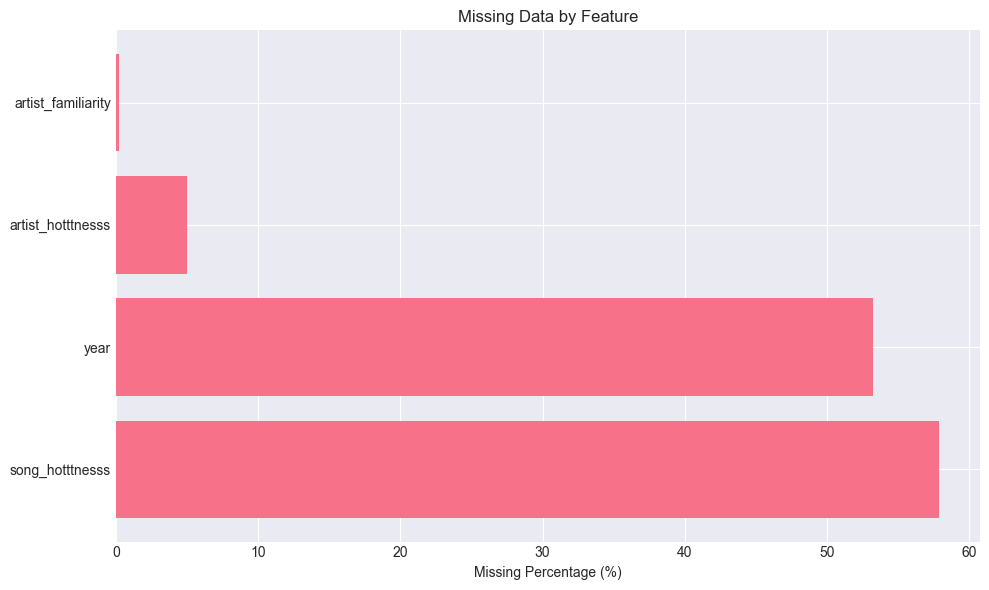

In [6]:
# Count missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("Missing Data Summary:")
print(missing_data)

# Visualize missing data
if len(missing_data) > 0:
    plt.figure(figsize=(10, 6))
    plt.barh(missing_data['Column'], missing_data['Missing Percentage'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Data by Feature')
    plt.tight_layout()
    plt.show()

In [7]:
# Detailed diagnostic of data loss
print("="*50)
print("=== DATA LOSS DIAGNOSTIC ===")
print("="*50)
print(f"Original dataset: {len(df)} songs\n")
print("Filter Impact:")
print(f"  Valid year (>0): {(df['year'] > 0).sum()} ({100*(df['year'] > 0).sum()/len(df):.1f}%)")
print(f"  Year 1950-2010: {((df['year'] >= 1950) & (df['year'] <= 2010)).sum()} ({100*((df['year'] >= 1950) & (df['year'] <= 2010)).sum()/len(df):.1f}%)")
print(f"  Has song_hotttnesss: {df['song_hotttnesss'].notna().sum()} ({100*df['song_hotttnesss'].notna().sum()/len(df):.1f}%)")
print(f"  Duration 30-600s: {((df['duration'] >= 30) & (df['duration'] <= 600)).sum()} ({100*((df['duration'] >= 30) & (df['duration'] <= 600)).sum()/len(df):.1f}%)")
print(f"\nNote: Data loss is inherent to MSD - many songs lack year or success metrics")
print("="*50)

# Data cleaning decisions
print("\nApplying filters...")

# Filter to songs with valid year (1950-2010)
df_clean = df[(df['year'] >= 1950) & (df['year'] <= 2010)].copy()
print(f"After year filter (1950-2010): {len(df_clean)} songs")

# Remove songs with missing song_hotttnesss
df_clean = df_clean[df_clean['song_hotttnesss'].notna()]
print(f"After removing missing hotttnesss: {len(df_clean)} songs")

# Remove extreme duration outliers
df_clean = df_clean[(df_clean['duration'] >= 30) & (df_clean['duration'] <= 600)]
print(f"After removing duration outliers (<30s or >600s): {len(df_clean)} songs")

# Reset index
df_clean = df_clean.reset_index(drop=True)

print(f"\n{'='*50}")
print(f"✓ Final clean dataset: {len(df_clean)} songs")
print(f"✓ Retention rate: {len(df_clean)/len(df)*100:.1f}%")
print(f"\nThis represents a high-quality subset with complete temporal and success metadata.")
print(f"The retention rate reflects known data quality issues in the Million Song Dataset.")
print(f"{'='*50}")

=== DATA LOSS DIAGNOSTIC ===
Original dataset: 10000 songs

Filter Impact:
  Valid year (>0): 4680 (46.8%)
  Year 1950-2010: 4664 (46.6%)
  Has song_hotttnesss: 4214 (42.1%)
  Duration 30-600s: 9835 (98.3%)

Note: Data loss is inherent to MSD - many songs lack year or success metrics

Applying filters...
After year filter (1950-2010): 4664 songs
After removing missing hotttnesss: 2712 songs
After removing duration outliers (<30s or >600s): 2689 songs

✓ Final clean dataset: 2689 songs
✓ Retention rate: 26.9%

This represents a high-quality subset with complete temporal and success metadata.
The retention rate reflects known data quality issues in the Million Song Dataset.


### 2.3 Feature Distributions

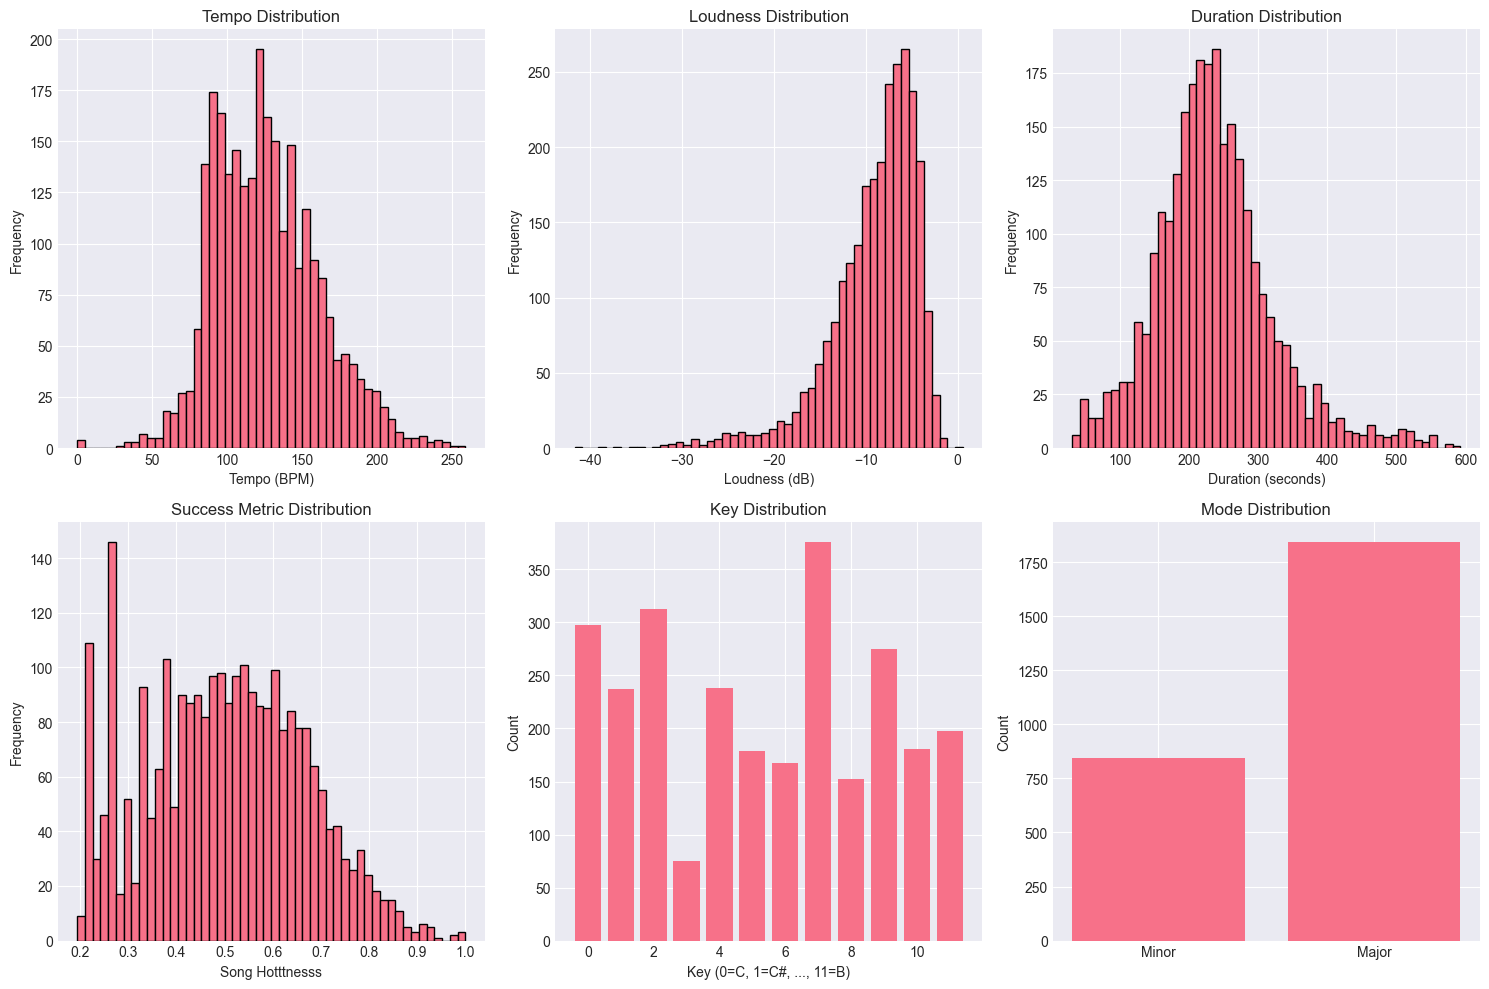


Key Statistics:
             tempo     loudness     duration  song_hotttnesss
count  2689.000000  2689.000000  2689.000000      2689.000000
mean    126.120819    -9.140543   236.106160         0.502231
std      35.102601     4.929613    84.313594         0.164366
min       0.000000   -41.691000    31.320360         0.193858
25%      99.237000   -11.382000   184.450160         0.375984
50%     122.956000    -7.991000   229.642000         0.503381
75%     148.633000    -5.726000   277.890160         0.624024
max     258.677000     0.566000   592.561180         1.000000


In [8]:
# Distribution of key audio features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Tempo
axes[0, 0].hist(df_clean['tempo'], bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Tempo (BPM)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Tempo Distribution')

# Loudness
axes[0, 1].hist(df_clean['loudness'], bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Loudness (dB)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Loudness Distribution')

# Duration
axes[0, 2].hist(df_clean['duration'], bins=50, edgecolor='black')
axes[0, 2].set_xlabel('Duration (seconds)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Duration Distribution')

# Song Hotttnesss
axes[1, 0].hist(df_clean['song_hotttnesss'], bins=50, edgecolor='black')
axes[1, 0].set_xlabel('Song Hotttnesss')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Success Metric Distribution')

# Key
key_counts = df_clean['key'].value_counts().sort_index()
axes[1, 1].bar(key_counts.index, key_counts.values)
axes[1, 1].set_xlabel('Key (0=C, 1=C#, ..., 11=B)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Key Distribution')

# Mode (Major/Minor)
mode_counts = df_clean['mode'].value_counts()
axes[1, 2].bar(['Minor', 'Major'], [mode_counts[0], mode_counts[1]])
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Mode Distribution')

plt.tight_layout()
plt.show()

print("\nKey Statistics:")
print(df_clean[['tempo', 'loudness', 'duration', 'song_hotttnesss']].describe())

### 2.4 Correlation Analysis

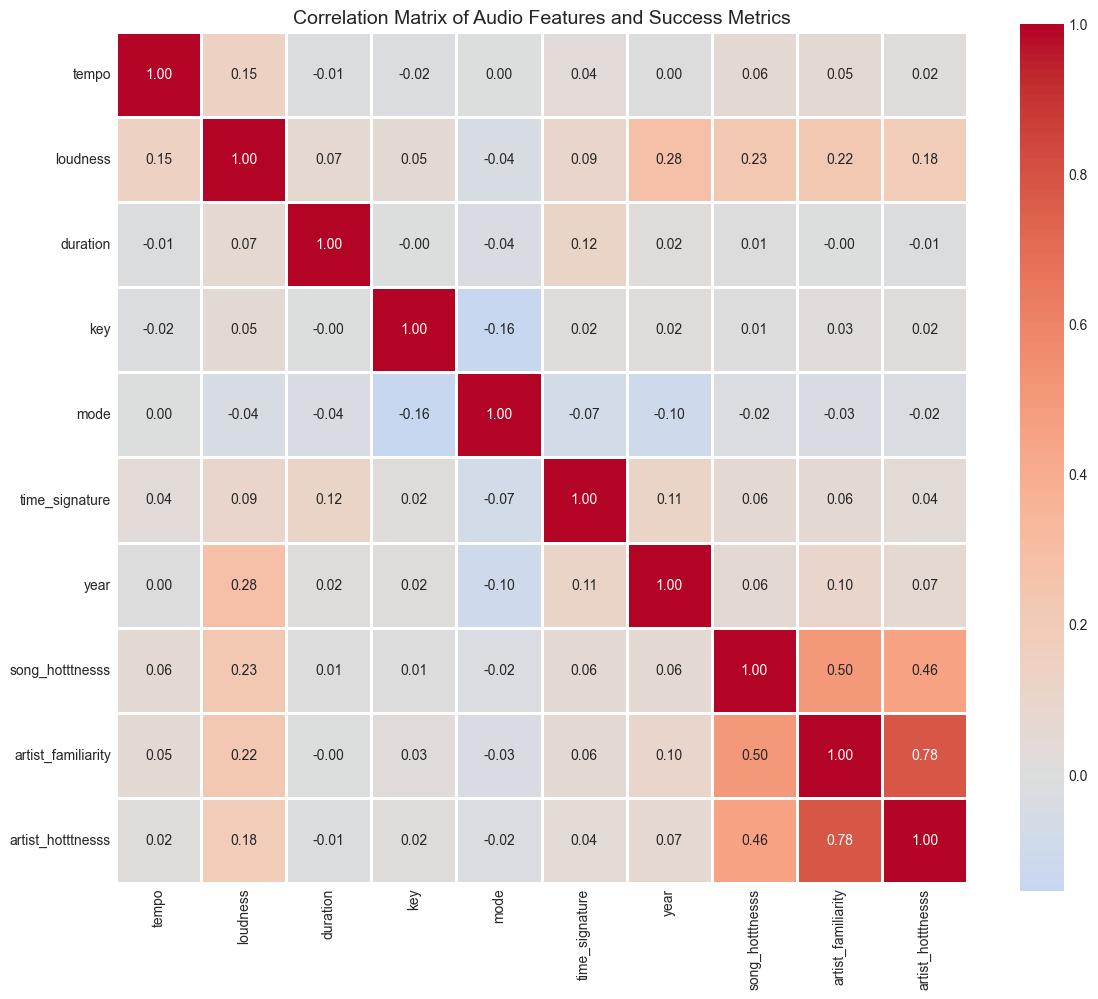


Correlations with Song Hotttnesss:
song_hotttnesss       1.000000
artist_familiarity    0.503953
artist_hotttnesss     0.460302
loudness              0.225452
year                  0.062324
tempo                 0.061968
time_signature        0.059913
key                   0.011319
duration              0.008906
mode                 -0.024198
Name: song_hotttnesss, dtype: float64

Correlations with Year (Temporal Trends):
year                  1.000000
loudness              0.281602
time_signature        0.114752
artist_familiarity    0.097463
artist_hotttnesss     0.070288
song_hotttnesss       0.062324
key                   0.021602
duration              0.020131
tempo                 0.004429
mode                 -0.104495
Name: year, dtype: float64


In [9]:
# Select numeric features for correlation
numeric_features = ['tempo', 'loudness', 'duration', 'key', 'mode', 'time_signature',
                    'year', 'song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss']

# Compute correlation matrix
corr_matrix = df_clean[numeric_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Correlation Matrix of Audio Features and Success Metrics', fontsize=14)
plt.tight_layout()
plt.show()

# Key correlations with success
print("\nCorrelations with Song Hotttnesss:")
success_corr = corr_matrix['song_hotttnesss'].sort_values(ascending=False)
print(success_corr)

# Key correlations with year (temporal trends)
print("\nCorrelations with Year (Temporal Trends):")
year_corr = corr_matrix['year'].sort_values(ascending=False)
print(year_corr)

### 2.5 Temporal Analysis

Investigating how musical features have evolved over time, particularly testing the "loudness war" hypothesis.

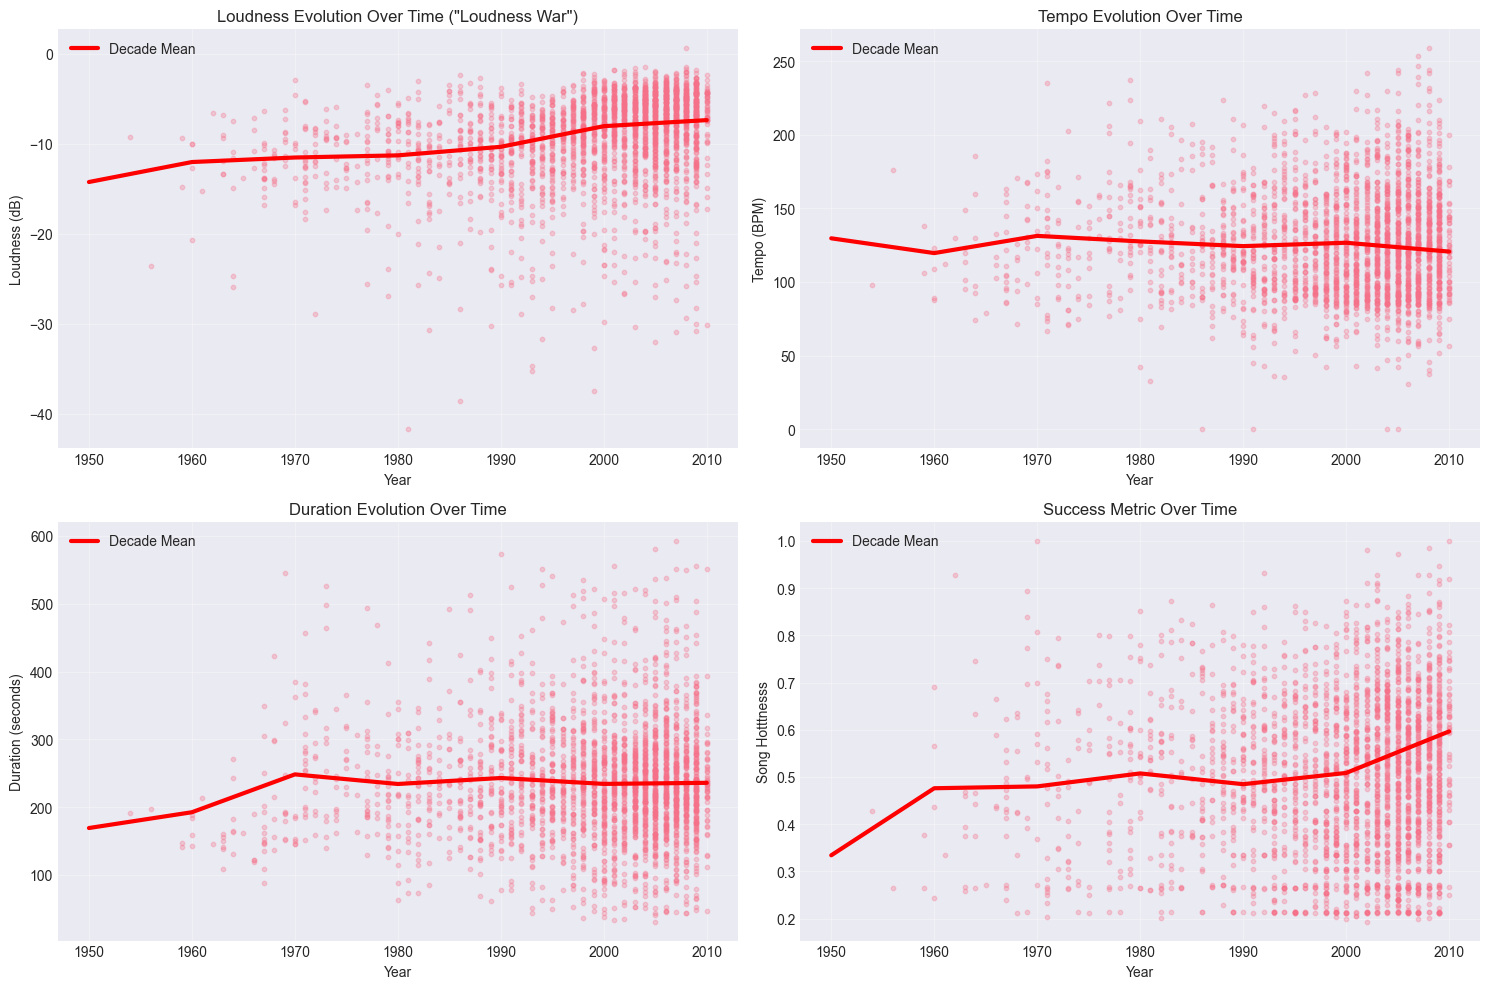


Mean Features by Decade:
             tempo                    loudness                    duration  \
              mean        std count       mean       std count        mean   
decade                                                                       
1950.0  129.653750  35.535514     4 -14.262000  6.708544     4  169.214240   
1960.0  119.608415  27.317327    53 -12.044038  3.931559    53  192.502281   
1970.0  131.301926  36.633337   121 -11.542132  4.458476   121  248.304003   
1980.0  127.541646  33.997252   243 -11.303473  5.478737   243  234.148064   
1990.0  124.335370  35.056505   649 -10.354912  5.017166   649  242.981712   
2000.0  126.629520  35.554334  1568  -8.063073  4.521331  1568  234.274915   
2010.0  120.629922  28.816274    51  -7.391353  4.622897    51  235.863236   

                        song_hotttnesss                  
              std count            mean       std count  
decade                                                   
1950.0  28.751793  

In [10]:
# Create decade feature
df_clean['decade'] = (df_clean['year'] // 10) * 10

# Temporal evolution of key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loudness over time (scatter + trend line)
axes[0, 0].scatter(df_clean['year'], df_clean['loudness'], alpha=0.3, s=10)
decade_loudness = df_clean.groupby('decade')['loudness'].mean()
axes[0, 0].plot(decade_loudness.index, decade_loudness.values, 'r-', linewidth=3, label='Decade Mean')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Loudness (dB)')
axes[0, 0].set_title('Loudness Evolution Over Time ("Loudness War")')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Tempo over time
axes[0, 1].scatter(df_clean['year'], df_clean['tempo'], alpha=0.3, s=10)
decade_tempo = df_clean.groupby('decade')['tempo'].mean()
axes[0, 1].plot(decade_tempo.index, decade_tempo.values, 'r-', linewidth=3, label='Decade Mean')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Tempo (BPM)')
axes[0, 1].set_title('Tempo Evolution Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Duration over time
axes[1, 0].scatter(df_clean['year'], df_clean['duration'], alpha=0.3, s=10)
decade_duration = df_clean.groupby('decade')['duration'].mean()
axes[1, 0].plot(decade_duration.index, decade_duration.values, 'r-', linewidth=3, label='Decade Mean')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Duration (seconds)')
axes[1, 0].set_title('Duration Evolution Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Success over time
axes[1, 1].scatter(df_clean['year'], df_clean['song_hotttnesss'], alpha=0.3, s=10)
decade_success = df_clean.groupby('decade')['song_hotttnesss'].mean()
axes[1, 1].plot(decade_success.index, decade_success.values, 'r-', linewidth=3, label='Decade Mean')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Song Hotttnesss')
axes[1, 1].set_title('Success Metric Over Time')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print decade statistics
print("\nMean Features by Decade:")
decade_stats = df_clean.groupby('decade')[['tempo', 'loudness', 'duration', 'song_hotttnesss']].agg(['mean', 'std', 'count'])
print(decade_stats)

In [11]:
# Create success tier categories
df_clean['success_tier'] = pd.cut(df_clean['song_hotttnesss'], 
                                   bins=[0, 0.33, 0.67, 1.0],
                                   labels=['Low', 'Medium', 'High'])

print("Success Tier Distribution:")
print(df_clean['success_tier'].value_counts().sort_index())

Success Tier Distribution:
success_tier
Low        469
Medium    1790
High       430
Name: count, dtype: int64


### 2.6 Box Plots by Decade

Examining how feature distributions vary across decades.

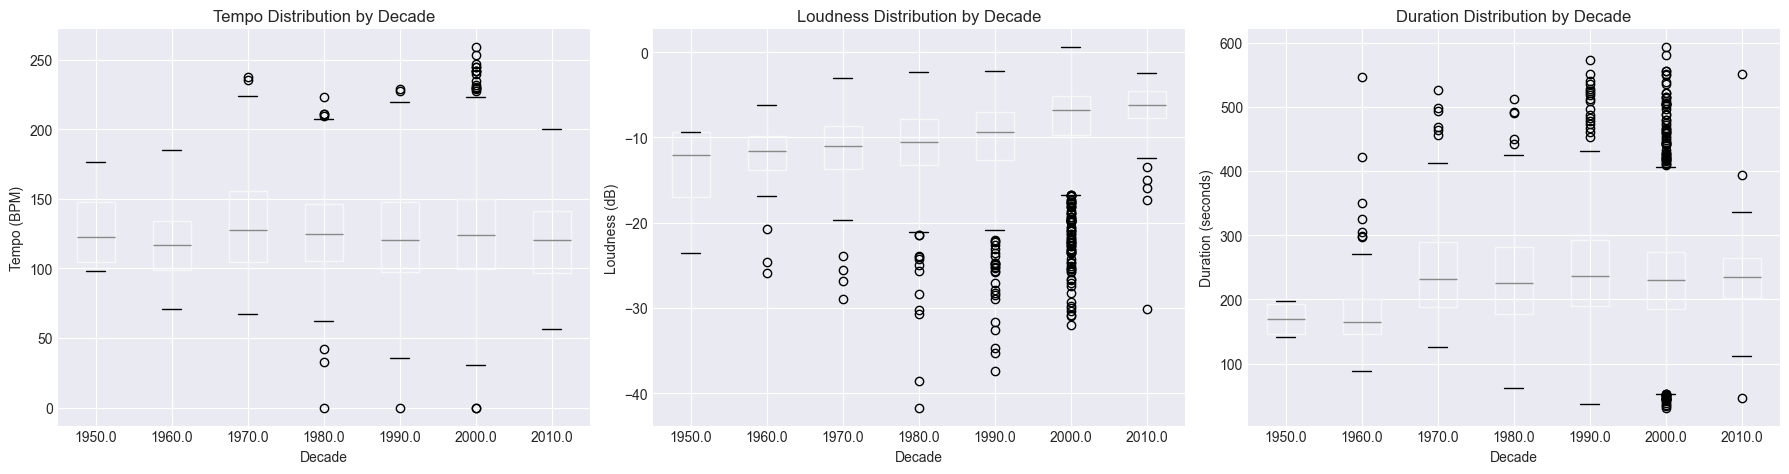

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Tempo by decade
df_clean.boxplot(column='tempo', by='decade', ax=axes[0])
axes[0].set_xlabel('Decade')
axes[0].set_ylabel('Tempo (BPM)')
axes[0].set_title('Tempo Distribution by Decade')
axes[0].get_figure().suptitle('')

# Loudness by decade
df_clean.boxplot(column='loudness', by='decade', ax=axes[1])
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Loudness (dB)')
axes[1].set_title('Loudness Distribution by Decade')
axes[1].get_figure().suptitle('')

# Duration by decade
df_clean.boxplot(column='duration', by='decade', ax=axes[2])
axes[2].set_xlabel('Decade')
axes[2].set_ylabel('Duration (seconds)')
axes[2].set_title('Duration Distribution by Decade')
axes[2].get_figure().suptitle('')

plt.tight_layout()
plt.show()

---
## Section 3: Feature Engineering

### 3.1 Timbre Dimensionality Reduction

Reducing the 12-dimensional timbre vector to 3 principal components.

Timbre PCA Explained Variance:
PC1: 0.516
PC2: 0.220
PC3: 0.095
Total: 0.831


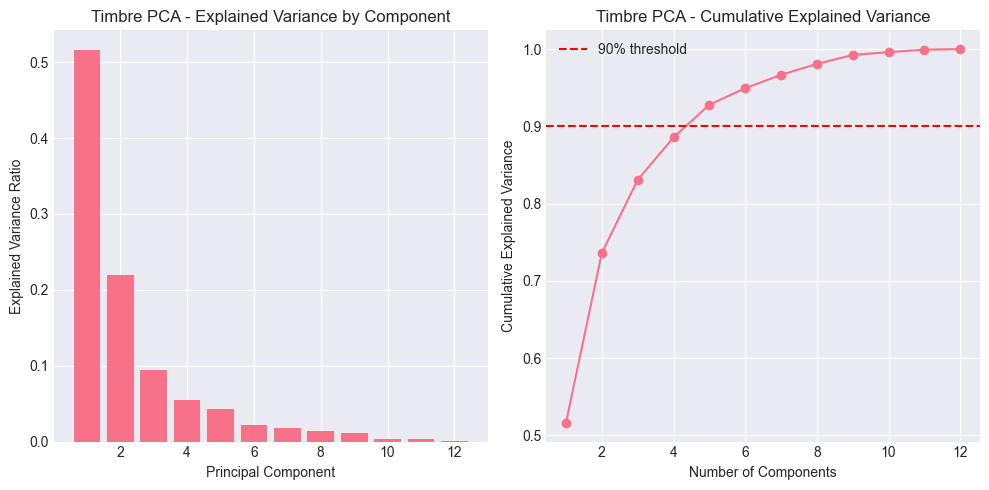

In [13]:
# Extract timbre features
timbre_cols = [f'timbre_{i+1}' for i in range(12)]
timbre_data = df_clean[timbre_cols].values

# Apply PCA to timbre - first fit with all components to see variance
pca_timbre_full = PCA()
pca_timbre_full.fit(timbre_data)

# Now fit with 3 components for actual use
pca_timbre = PCA(n_components=3)
timbre_pcs = pca_timbre.fit_transform(timbre_data)

# Add to dataframe
df_clean['timbre_pc1'] = timbre_pcs[:, 0]
df_clean['timbre_pc2'] = timbre_pcs[:, 1]
df_clean['timbre_pc3'] = timbre_pcs[:, 2]

# Explained variance
print("Timbre PCA Explained Variance:")
print(f"PC1: {pca_timbre.explained_variance_ratio_[0]:.3f}")
print(f"PC2: {pca_timbre.explained_variance_ratio_[1]:.3f}")
print(f"PC3: {pca_timbre.explained_variance_ratio_[2]:.3f}")
print(f"Total: {pca_timbre.explained_variance_ratio_.sum():.3f}")

# Visualize explained variance using the full PCA
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, 13), pca_timbre_full.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Timbre PCA - Explained Variance by Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, 13), np.cumsum(pca_timbre_full.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Timbre PCA - Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3.2 Feature Transformation and Scaling

In [14]:
# Log transform duration (right-skewed distribution)
df_clean['duration_log'] = np.log(df_clean['duration'])

# Define features for clustering
clustering_features = [
    'tempo',
    'loudness',
    'duration_log',
    'mode',
    'timbre_pc1',
    'timbre_pc2',
    'timbre_pc3'
]

print("Features selected for clustering:")
for i, feat in enumerate(clustering_features, 1):
    print(f"{i}. {feat}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[clustering_features])

print(f"\nScaled feature matrix shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean(axis=0).round(2)}")
print(f"Std: {X_scaled.std(axis=0).round(2)}")

Features selected for clustering:
1. tempo
2. loudness
3. duration_log
4. mode
5. timbre_pc1
6. timbre_pc2
7. timbre_pc3

Scaled feature matrix shape: (2689, 7)
Mean: [ 0.  0.  0. -0.  0. -0.  0.]
Std: [1. 1. 1. 1. 1. 1. 1.]


---
## Section 4: Dimensionality Reduction & Visualization

### 4.1 PCA on All Features

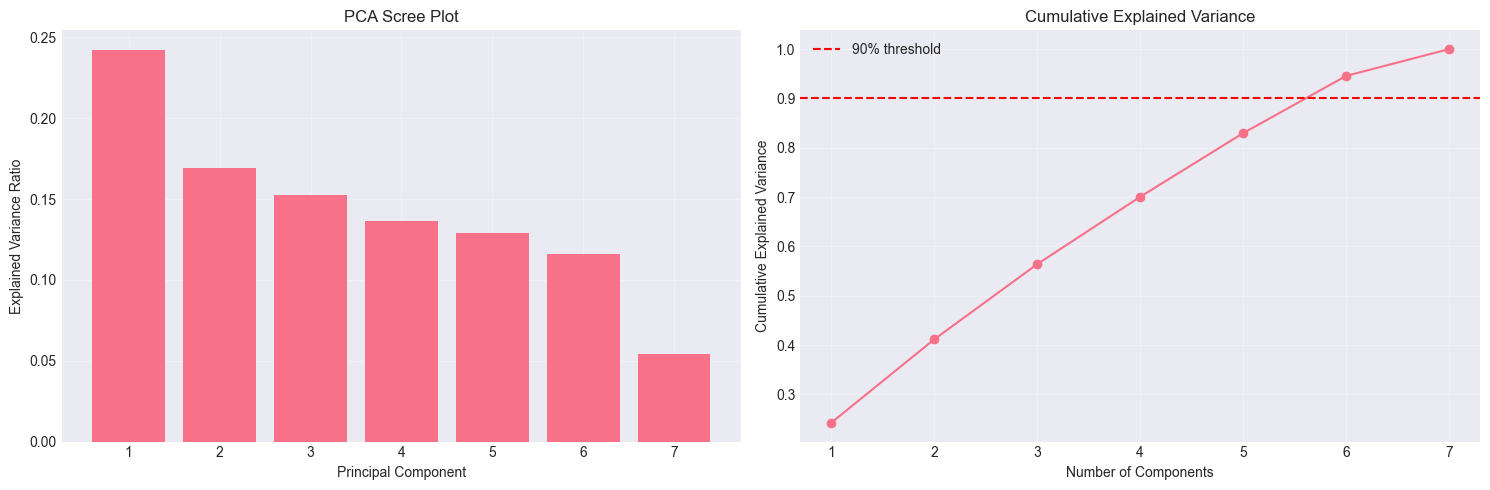

Components needed for 90% variance: 6
Variance explained by first 2 PCs: 0.411


In [15]:
# Apply PCA to all clustering features
pca_full = PCA()
X_pca = pca_full.fit_transform(X_scaled)

# Explained variance
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(range(1, len(explained_var) + 1), explained_var)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Scree Plot')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Number of components for 90% variance
n_components_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f"Components needed for 90% variance: {n_components_90}")
print(f"Variance explained by first 2 PCs: {cumulative_var[1]:.3f}")

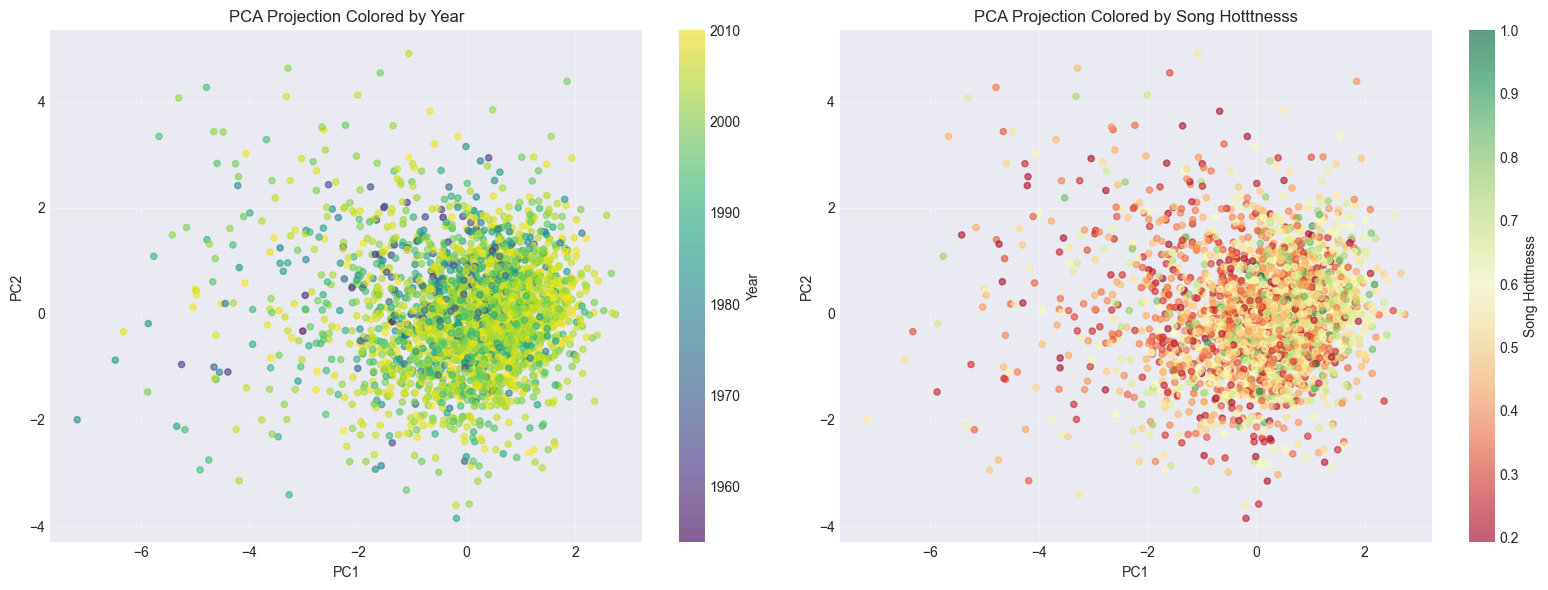

In [16]:
# Visualize 2D PCA projections
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colored by year
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=df_clean['year'], 
                          cmap='viridis', 
                          alpha=0.6, s=20)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA Projection Colored by Year')
plt.colorbar(scatter1, ax=axes[0], label='Year')
axes[0].grid(True, alpha=0.3)

# Colored by success
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=df_clean['song_hotttnesss'], 
                          cmap='RdYlGn', 
                          alpha=0.6, s=20)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('PCA Projection Colored by Song Hotttnesss')
plt.colorbar(scatter2, ax=axes[1], label='Song Hotttnesss')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 t-SNE Visualization

Running t-SNE (this may take 1-2 minutes)...
t-SNE complete!


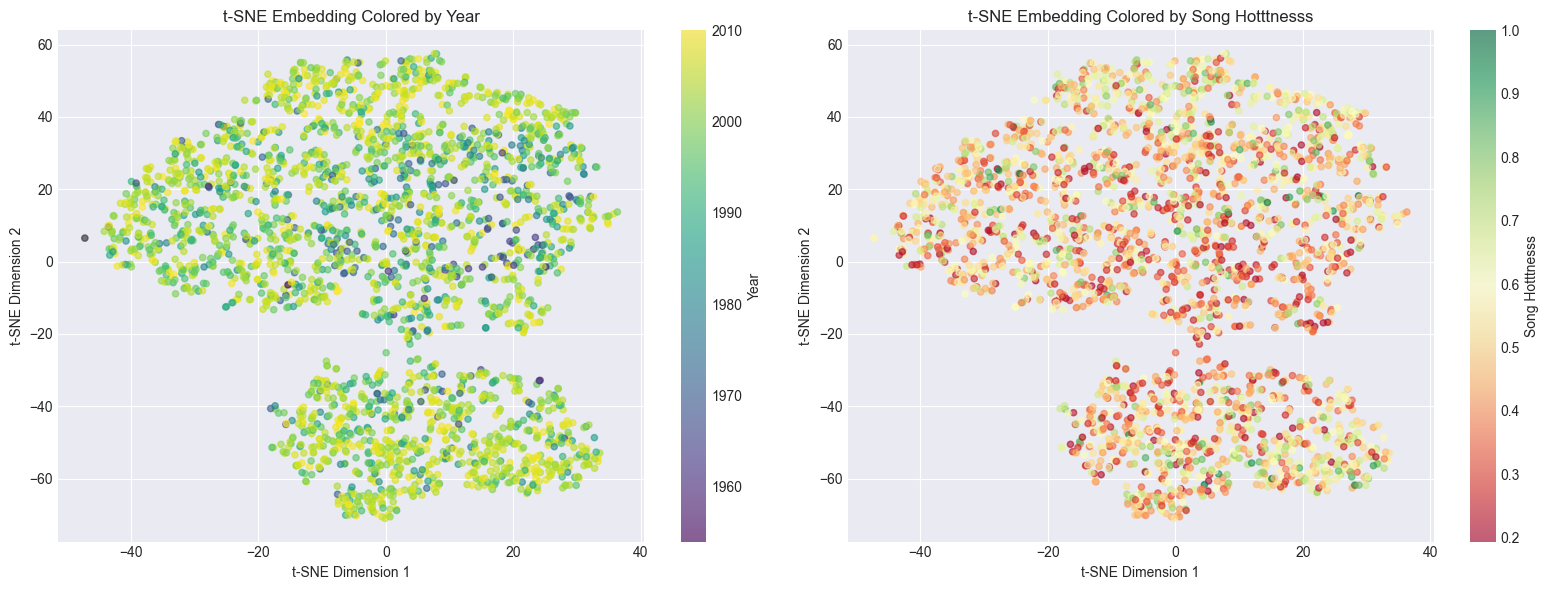

In [17]:
# Apply t-SNE (use PCA-reduced features for speed)
print("Running t-SNE (this may take 1-2 minutes)...")
pca_for_tsne = PCA(n_components=n_components_90)
X_pca_reduced = pca_for_tsne.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca_reduced)

print("t-SNE complete!")

# Visualize t-SNE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colored by year
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=df_clean['year'], 
                          cmap='viridis', 
                          alpha=0.6, s=20)
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
axes[0].set_title('t-SNE Embedding Colored by Year')
plt.colorbar(scatter1, ax=axes[0], label='Year')

# Colored by success
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=df_clean['song_hotttnesss'], 
                          cmap='RdYlGn', 
                          alpha=0.6, s=20)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('t-SNE Embedding Colored by Song Hotttnesss')
plt.colorbar(scatter2, ax=axes[1], label='Song Hotttnesss')

plt.tight_layout()
plt.show()

---
## Section 5: Clustering - K-Means

### 5.1 Hyperparameter Tuning: Finding Optimal k

In [18]:
# Test range of k values
k_range = range(2, 16)
inertias = []
silhouette_scores_list = []
db_scores = []
ch_scores = []

print("Testing K-means with different k values...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores_list.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    if k % 2 == 0:
        print(f"k={k}: Silhouette={silhouette_scores_list[-1]:.3f}, DB={db_scores[-1]:.3f}")

print("\nHyperparameter tuning complete!")

Testing K-means with different k values...
k=2: Silhouette=0.225, DB=2.026
k=4: Silhouette=0.147, DB=1.850
k=6: Silhouette=0.129, DB=1.775
k=8: Silhouette=0.126, DB=1.806
k=10: Silhouette=0.134, DB=1.683
k=12: Silhouette=0.133, DB=1.625
k=14: Silhouette=0.128, DB=1.629

Hyperparameter tuning complete!


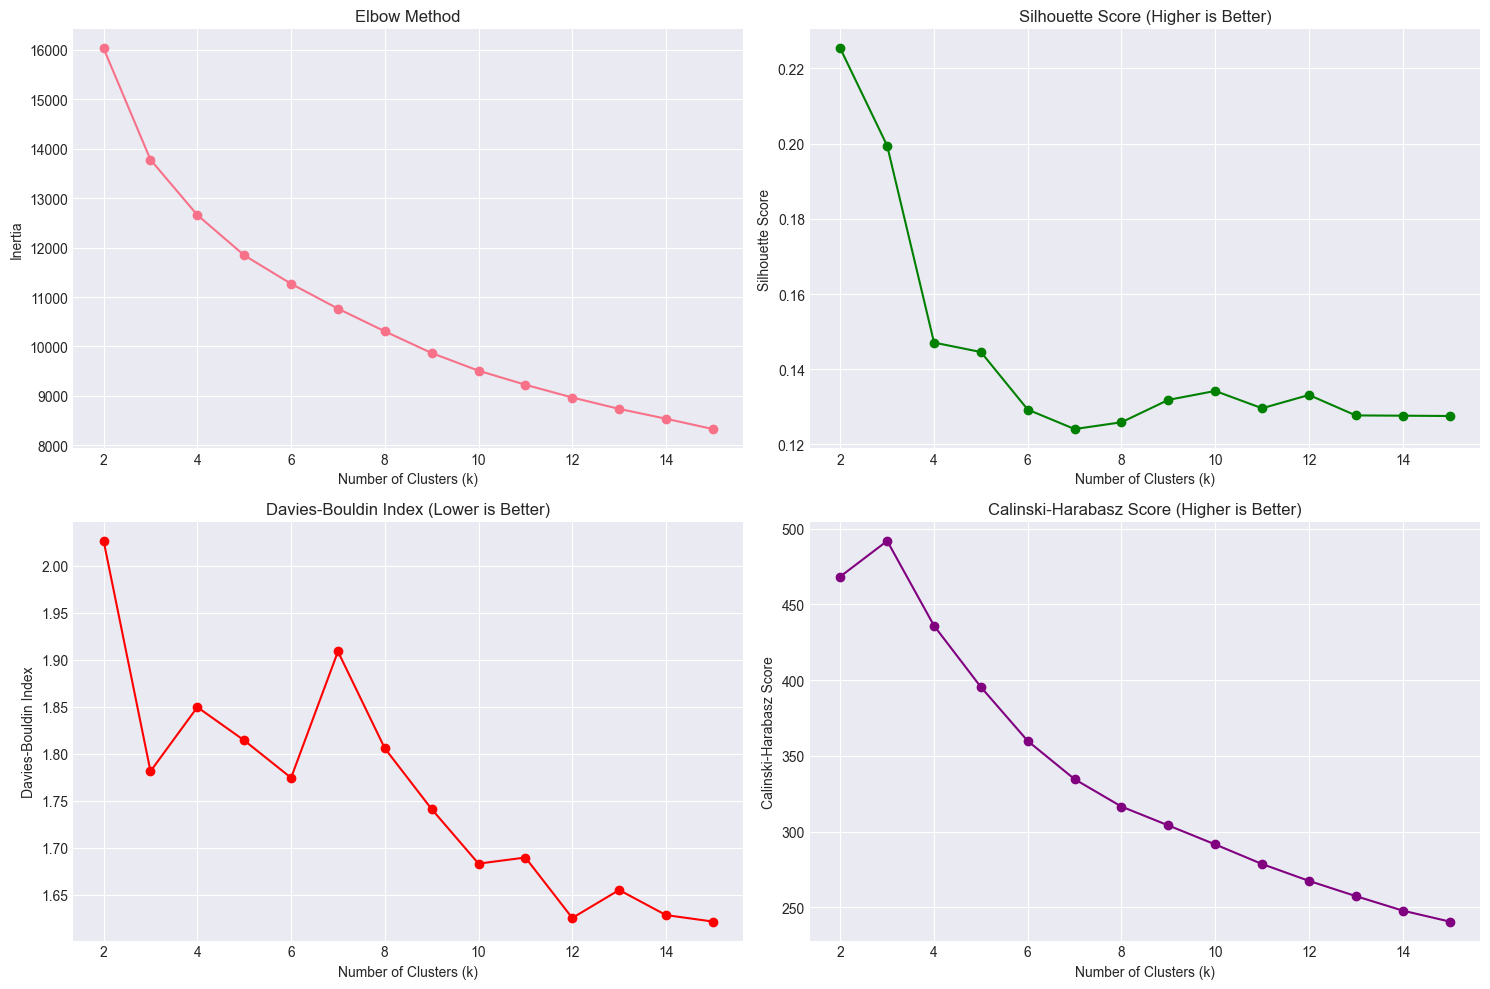


Optimal k by silhouette score: 2
Silhouette score: 0.225

Selected k = 5 for final model
Expected cluster size: ~537 songs per cluster
(Reduced k to avoid overfitting with modest sample size)


In [19]:
# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow method
axes[0, 0].plot(k_range, inertias, marker='o')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True)

# Silhouette score (higher is better)
axes[0, 1].plot(k_range, silhouette_scores_list, marker='o', color='green')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher is Better)')
axes[0, 1].grid(True)

# Davies-Bouldin index (lower is better)
axes[1, 0].plot(k_range, db_scores, marker='o', color='red')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)')
axes[1, 0].grid(True)

# Calinski-Harabasz score (higher is better)
axes[1, 1].plot(k_range, ch_scores, marker='o', color='purple')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Select optimal k
optimal_k_silhouette = k_range[np.argmax(silhouette_scores_list)]
print(f"\nOptimal k by silhouette score: {optimal_k_silhouette}")
print(f"Silhouette score: {max(silhouette_scores_list):.3f}")

# Choose k (balance metrics and interpretability)
# Reduced from 6 to 5 for better cluster sizes with smaller dataset (N~2,700)
# This avoids overfitting and ensures ~540 songs per cluster vs ~450 with k=6
optimal_k = 5  
print(f"\nSelected k = {optimal_k} for final model")
print(f"Expected cluster size: ~{len(df_clean)//optimal_k} songs per cluster")
print(f"(Reduced k to avoid overfitting with modest sample size)")

### 5.2 Train Final K-Means Model

In [20]:
# Train final K-means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_clean['kmeans_cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"K-means clustering complete with k={optimal_k}")
print(f"\nCluster distribution:")
print(df_clean['kmeans_cluster'].value_counts().sort_index())

K-means clustering complete with k=5

Cluster distribution:
kmeans_cluster
0    786
1    214
2    652
3    313
4    724
Name: count, dtype: int64


### 5.3 Analyze K-Means Clusters

K-Means Cluster Profiles:
                  tempo  loudness  duration_log   mode  timbre_pc1  \
kmeans_cluster                                                       
0               109.659    -8.058         5.542  1.000      10.564   
1               108.721   -16.601         4.822  0.710     -63.854   
2               154.752    -6.872         5.312  0.988      24.134   
3               119.253   -15.271         5.452  0.837     -61.083   
4               126.321    -7.504         5.453  0.000      12.079   

                timbre_pc2  timbre_pc3  
kmeans_cluster                          
0                   -2.275       7.493  
1                   35.746      16.606  
2                   11.764     -10.061  
3                  -33.395     -11.049  
4                   -4.252       0.794  


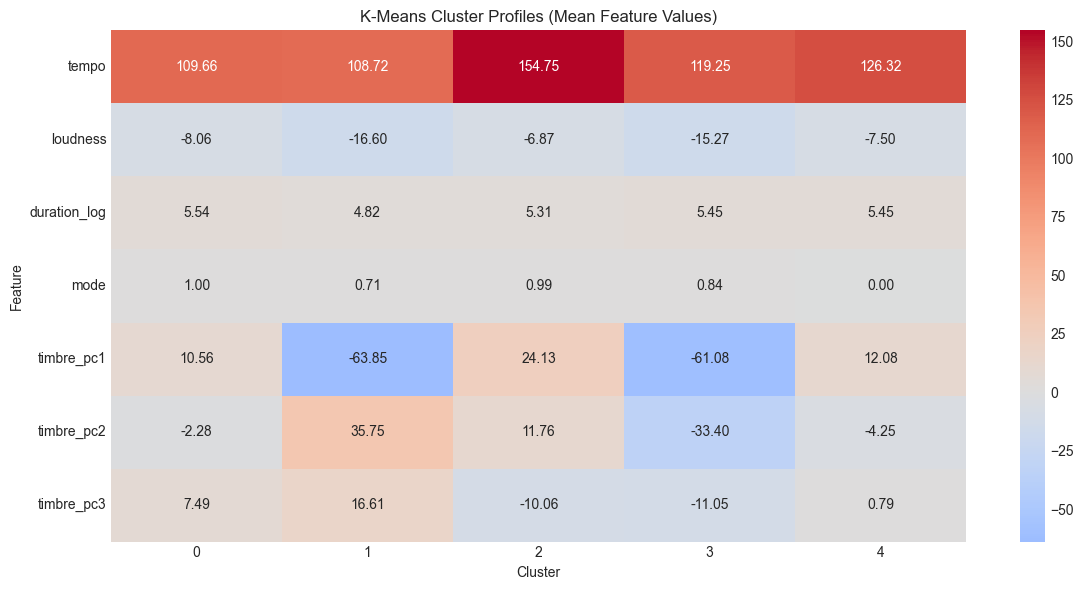

In [21]:
# Cluster profiles (mean features per cluster)
cluster_profiles = df_clean.groupby('kmeans_cluster')[clustering_features].mean()

print("K-Means Cluster Profiles:")
print(cluster_profiles.round(3))

# Visualize cluster profiles as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('K-Means Cluster Profiles (Mean Feature Values)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

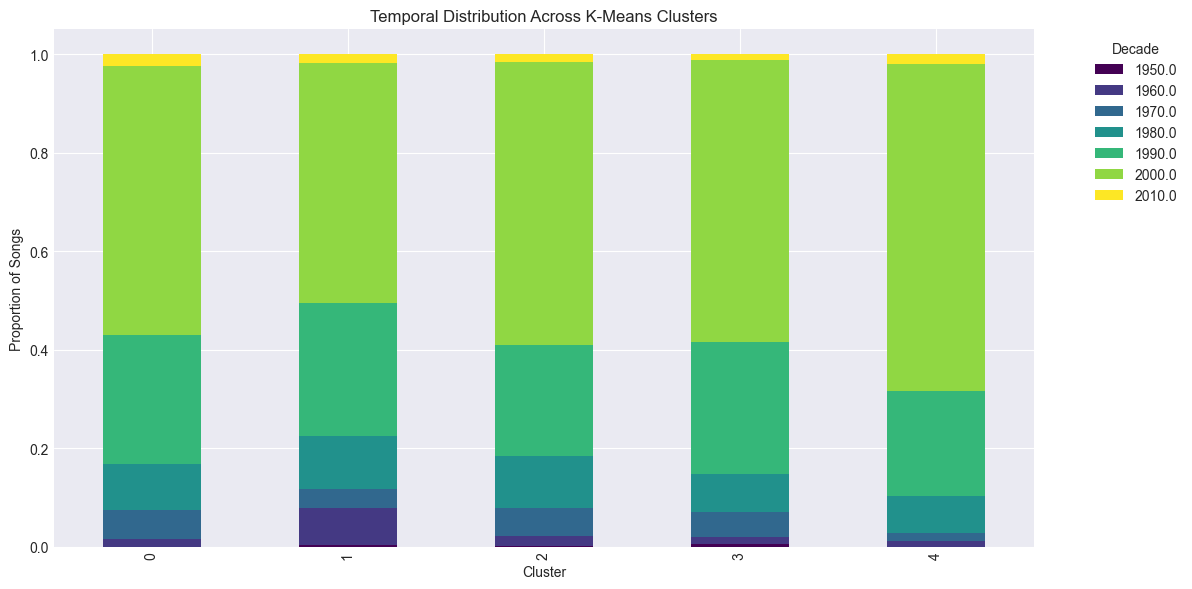


Temporal Distribution (Raw Counts):
decade          1950.0  1960.0  1970.0  1980.0  1990.0  2000.0  2010.0
kmeans_cluster                                                        
0                    0      12      46      74     206     429      19
1                    1      16       8      23      58     104       4
2                    1      13      38      68     147     375      10
3                    2       4      16      24      84     179       4
4                    0       8      13      54     154     481      14


In [22]:
# Temporal distribution of clusters
temporal_dist = pd.crosstab(df_clean['kmeans_cluster'], df_clean['decade'], normalize='index')

# Stacked bar chart
temporal_dist.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Songs')
plt.title('Temporal Distribution Across K-Means Clusters')
plt.legend(title='Decade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nTemporal Distribution (Raw Counts):")
print(pd.crosstab(df_clean['kmeans_cluster'], df_clean['decade']))


Success Metrics by Cluster:
                    mean       std  count
kmeans_cluster                           
0               0.496847  0.162000    786
1               0.426004  0.150874    214
2               0.533443  0.161732    652
3               0.471651  0.162196    313
4               0.515720  0.164680    724


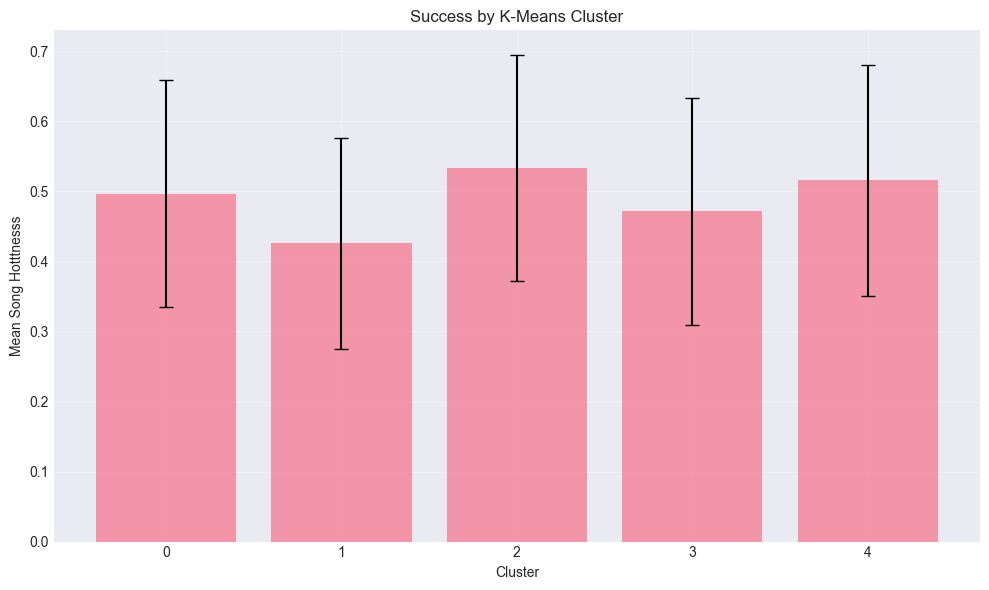


ANOVA Test:
F-statistic: 22.2017
p-value: 4.6914e-18
Success differences across clusters are statistically significant (p < 0.05)


In [23]:
# Success by cluster
success_by_cluster = df_clean.groupby('kmeans_cluster')['song_hotttnesss'].agg(['mean', 'std', 'count'])

print("\nSuccess Metrics by Cluster:")
print(success_by_cluster)

# Bar chart with error bars
plt.figure(figsize=(10, 6))
plt.bar(success_by_cluster.index, success_by_cluster['mean'], 
        yerr=success_by_cluster['std'], capsize=5, alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Mean Song Hotttnesss')
plt.title('Success by K-Means Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ANOVA test: Are success differences significant?
cluster_groups = [df_clean[df_clean['kmeans_cluster']==i]['song_hotttnesss'].values 
                  for i in range(optimal_k)]
f_stat, p_value = f_oneway(*cluster_groups)
print(f"\nANOVA Test:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")
if p_value < 0.05:
    print("Success differences across clusters are statistically significant (p < 0.05)")
else:
    print("Success differences across clusters are NOT statistically significant (p >= 0.05)")

### 5.4 Visualize K-Means Clusters

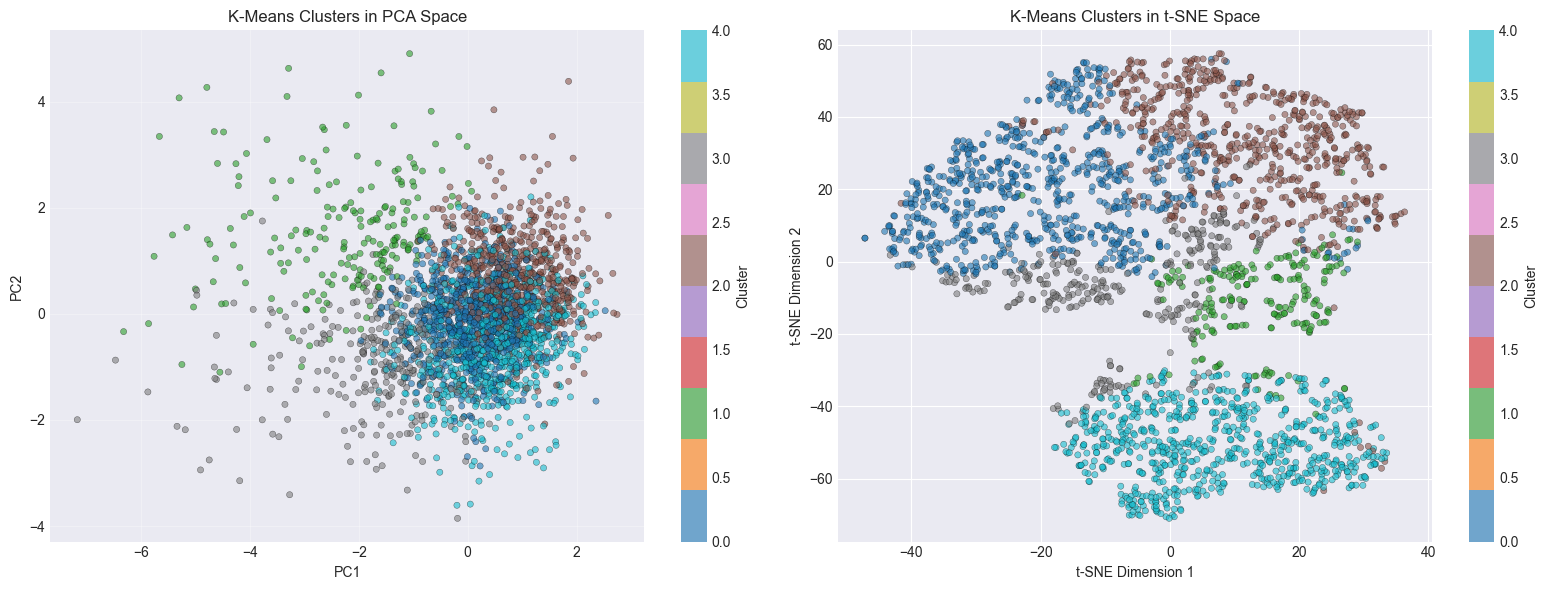

In [24]:
# Visualize clusters in PCA and t-SNE space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA projection
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=df_clean['kmeans_cluster'], 
                          cmap='tab10', 
                          alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('K-Means Clusters in PCA Space')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# t-SNE projection
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=df_clean['kmeans_cluster'], 
                          cmap='tab10', 
                          alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('K-Means Clusters in t-SNE Space')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

### 5.5 Interpret Clusters

Examining representative songs from each cluster to understand their characteristics.

In [25]:
# Representative songs from each cluster
print("Representative Songs by Cluster:\n")

for cluster_id in range(optimal_k):
    cluster_songs = df_clean[df_clean['kmeans_cluster'] == cluster_id]
    
    # Get most successful songs in cluster
    top_songs = cluster_songs.nlargest(3, 'song_hotttnesss')[['artist_name', 'song_title', 'year', 'song_hotttnesss']]
    
    # Cluster statistics
    mean_year = cluster_songs['year'].mean()
    mean_success = cluster_songs['song_hotttnesss'].mean()
    size = len(cluster_songs)
    
    print(f"Cluster {cluster_id}: {size} songs, Mean Year: {mean_year:.0f}, Mean Success: {mean_success:.3f}")
    print("Top songs:")
    for idx, row in top_songs.iterrows():
        print(f"  - {row['artist_name']} - {row['song_title']} ({int(row['year'])})")
    print()

Representative Songs by Cluster:

Cluster 0: 786 songs, Mean Year: 1998, Mean Success: 0.497
Top songs:
  - B.o.B - Nothin' On You [feat. Bruno Mars] (Album Version) (2010)
  - Snow Patrol - Just Say Yes (2009)
  - Little Eva - The Loco-Motion (1962)

Cluster 1: 214 songs, Mean Year: 1995, Mean Success: 0.426
Top songs:
  - M83 - You Appearing (2008)
  - My Chemical Romance - Interlude (Album Version) (2004)
  - M83 - Let Men Burn Stars (2005)

Cluster 2: 652 songs, Mean Year: 1998, Mean Success: 0.533
Top songs:
  - Led Zeppelin - Immigrant Song (Album Version) (1970)
  - The White Stripes - Blue Orchid (2005)
  - Sean Kingston - Face Drop (2009)

Cluster 3: 313 songs, Mean Year: 1999, Mean Success: 0.472
Top songs:
  - Alicia Keys - Wait Til You See My Smile (2009)
  - Grizzly Bear - Little Brother (2006)
  - Charlotte Gainsbourg - IRM (2009)

Cluster 4: 724 songs, Mean Year: 2001, Mean Success: 0.516
Top songs:
  - Nickelback - If Today Was Your Last Day (Album Version) (2008)
  - M

---
## Section 6: Clustering - Hierarchical

### 6.1 Dendrogram

Computing hierarchical clustering linkage...
Linkage computation complete!


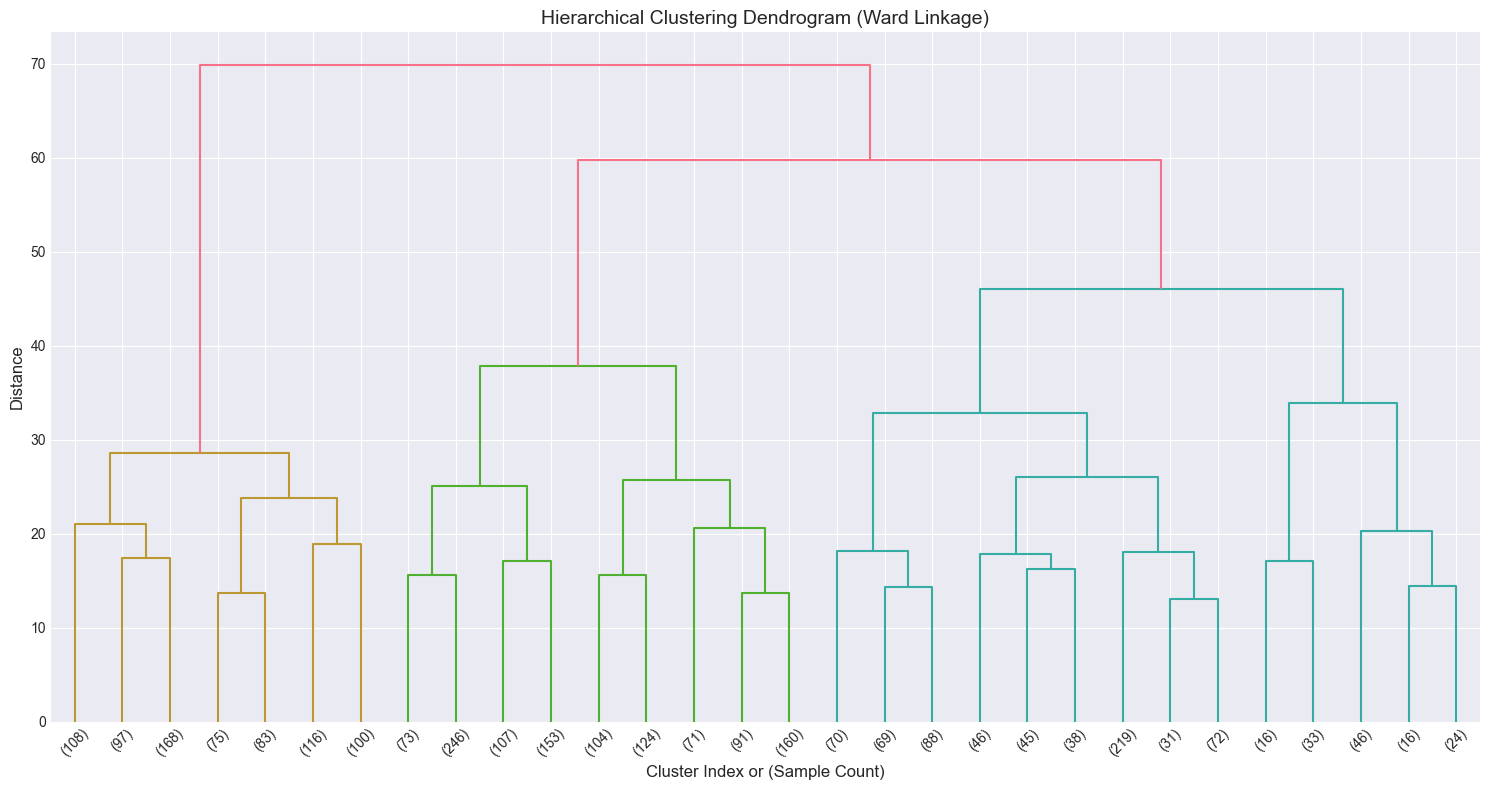

In [26]:
# Compute linkage (Ward method)
print("Computing hierarchical clustering linkage...")
Z = linkage(X_scaled, method='ward')
print("Linkage computation complete!")

# Plot dendrogram (truncated for readability)
plt.figure(figsize=(15, 8))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=14)
plt.xlabel('Cluster Index or (Sample Count)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

### 6.2 Train Hierarchical Clustering

In [27]:
# Train hierarchical clustering with same k as K-means
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df_clean['hierarchical_cluster'] = hierarchical.fit_predict(X_scaled)

print(f"Hierarchical clustering complete with k={optimal_k}")
print(f"\nCluster distribution:")
print(df_clean['hierarchical_cluster'].value_counts().sort_index())

Hierarchical clustering complete with k=5

Cluster distribution:
hierarchical_cluster
0    135
1    678
2    550
3    747
4    579
Name: count, dtype: int64


### 6.3 Analyze and Compare with K-Means

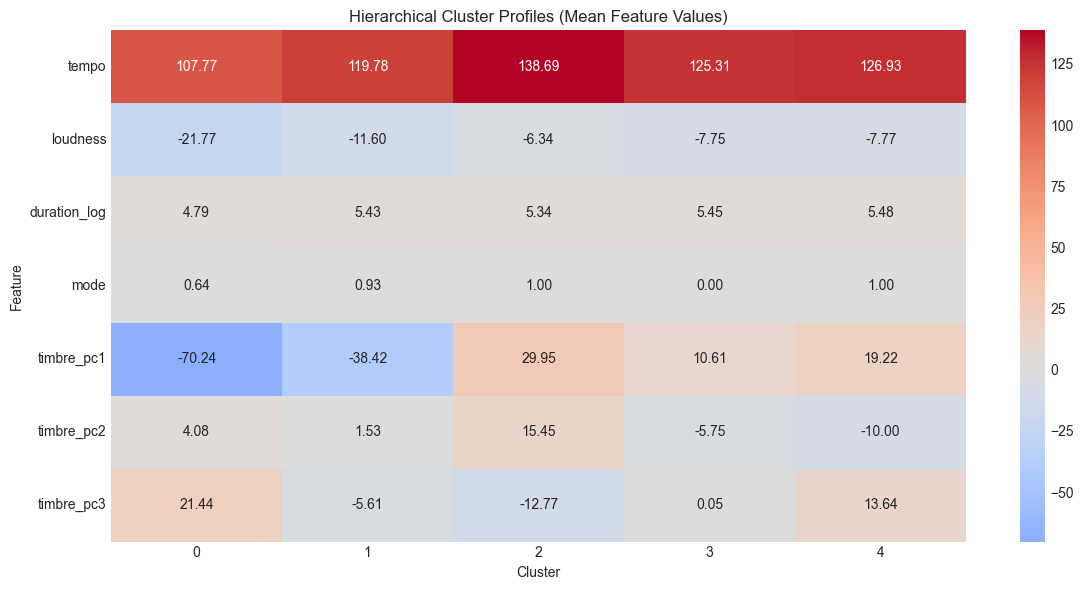

In [28]:
# Cluster profiles
hierarchical_profiles = df_clean.groupby('hierarchical_cluster')[clustering_features].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(hierarchical_profiles.T, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Hierarchical Cluster Profiles (Mean Feature Values)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

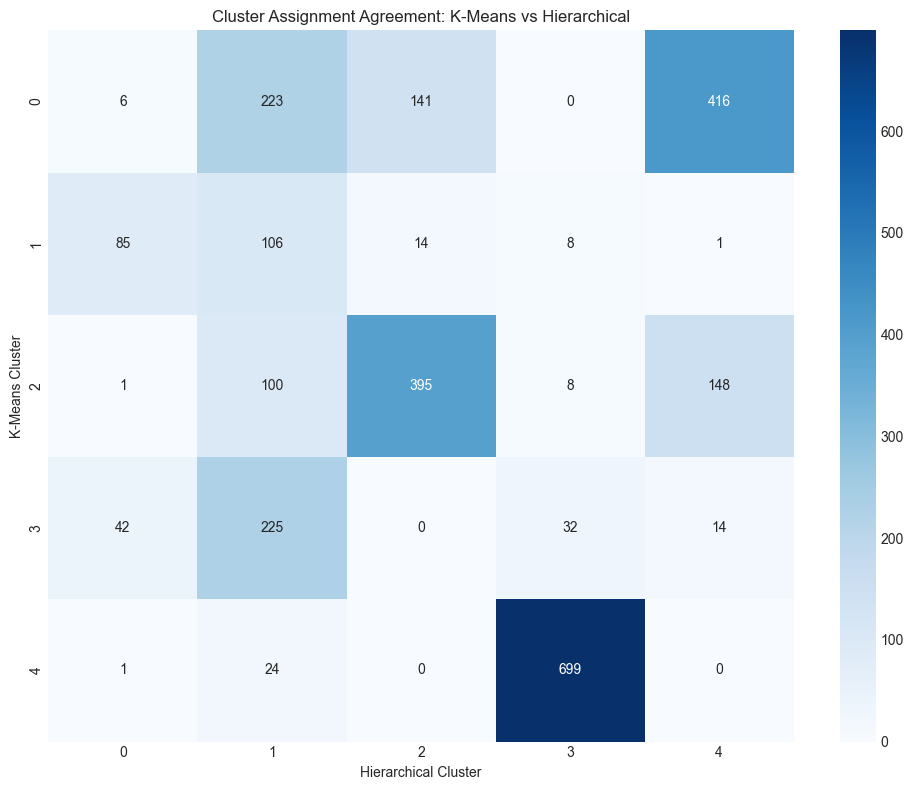


Agreement between K-means and Hierarchical:
Adjusted Rand Index: 0.459
Normalized Mutual Information: 0.489
Moderate agreement - some overlap in patterns


In [29]:
# Confusion matrix: Compare K-means vs Hierarchical
cm = confusion_matrix(df_clean['kmeans_cluster'], df_clean['hierarchical_cluster'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('K-Means Cluster')
plt.title('Cluster Assignment Agreement: K-Means vs Hierarchical')
plt.tight_layout()
plt.show()

# Agreement metrics
ari = adjusted_rand_score(df_clean['kmeans_cluster'], df_clean['hierarchical_cluster'])
nmi = normalized_mutual_info_score(df_clean['kmeans_cluster'], df_clean['hierarchical_cluster'])

print(f"\nAgreement between K-means and Hierarchical:")
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")

if ari > 0.5:
    print("High agreement - models find similar patterns")
elif ari > 0.2:
    print("Moderate agreement - some overlap in patterns")
else:
    print("Low agreement - models find different patterns")

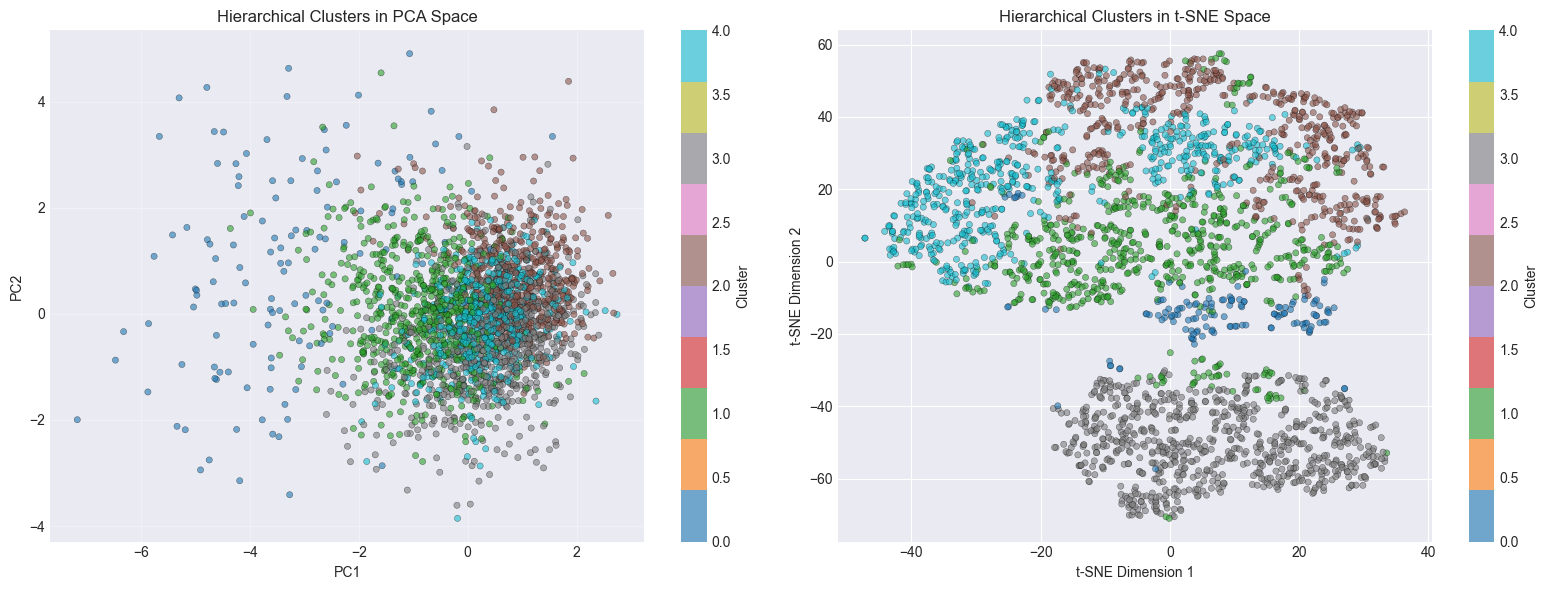

In [30]:
# Visualize hierarchical clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA projection
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=df_clean['hierarchical_cluster'], 
                          cmap='tab10', 
                          alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Hierarchical Clusters in PCA Space')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# t-SNE projection
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=df_clean['hierarchical_cluster'], 
                          cmap='tab10', 
                          alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('Hierarchical Clusters in t-SNE Space')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

---
## Section 7: Clustering - DBSCAN

### 7.1 Hyperparameter Tuning

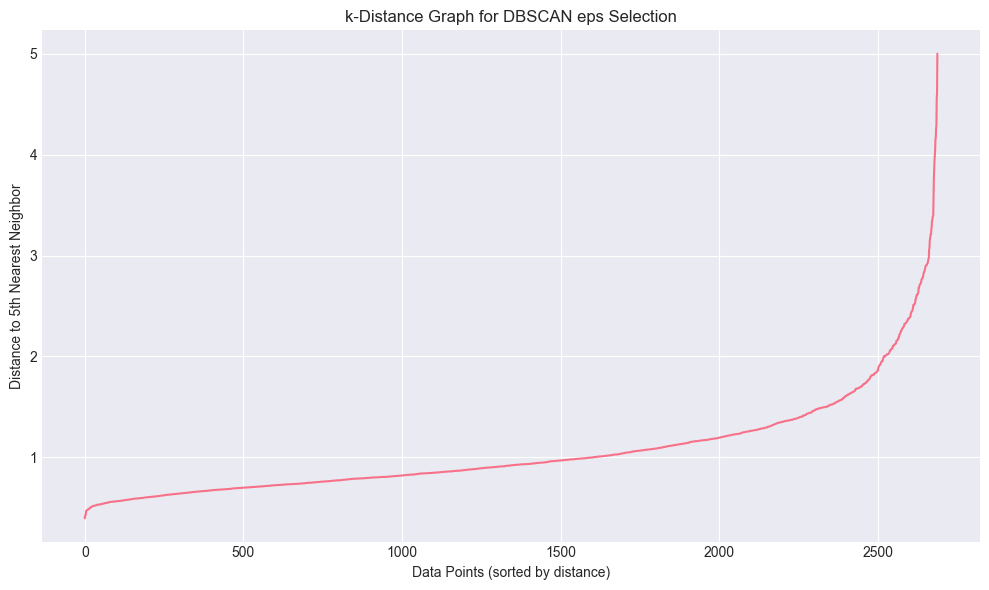

Look for 'elbow' in the k-distance graph to select eps


In [31]:
# k-distance graph to estimate eps
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, min_samples-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel(f'Distance to {min_samples}th Nearest Neighbor')
plt.title('k-Distance Graph for DBSCAN eps Selection')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Look for 'elbow' in the k-distance graph to select eps")

In [32]:
# Grid search for eps and min_samples
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_values = [3, 5, 7]

results = []
print("Testing DBSCAN parameters...")

for eps in eps_values:
    for min_samp in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:
            # Calculate silhouette only for non-noise points
            mask = labels != -1
            if mask.sum() > 0:
                silhouette = silhouette_score(X_scaled[mask], labels[mask])
            else:
                silhouette = -1
        else:
            silhouette = -1
        
        results.append({
            'eps': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': n_noise / len(X_scaled) * 100,
            'silhouette': silhouette
        })

results_df = pd.DataFrame(results)
print("\nDBSCAN Parameter Search Results:")
print(results_df.sort_values('silhouette', ascending=False))

# Select best parameters
best_params = results_df[results_df['noise_pct'] < 30].sort_values('silhouette', ascending=False).iloc[0]
eps_final = best_params['eps']
min_samples_final = int(best_params['min_samples'])

print(f"\nSelected parameters: eps={eps_final}, min_samples={min_samples_final}")

Testing DBSCAN parameters...

DBSCAN Parameter Search Results:
    eps  min_samples  n_clusters  n_noise   noise_pct  silhouette
12  2.5            3           2       25    0.929714    0.460421
1   0.5            5          12     2623   97.545556    0.412645
5   1.0            7           2      865   32.168092    0.265962
8   1.5            7           2      240    8.925251    0.221760
7   1.5            5           2      219    8.144292    0.219834
0   0.5            3          57     2375   88.322797    0.212997
10  2.0            5           2      112    4.165117    0.208478
11  2.0            7           2      113    4.202306    0.208447
6   1.5            3           3      204    7.586463    0.193103
9   2.0            3           8       82    3.049461    0.190081
4   1.0            5           4      763   28.374861    0.163992
3   1.0            3          18      620   23.056898   -0.056611
2   0.5            7           0     2689  100.000000   -1.000000
13  2.5      

### 7.2 Train DBSCAN

In [33]:
# Train DBSCAN with optimal parameters
dbscan_final = DBSCAN(eps=eps_final, min_samples=min_samples_final)
df_clean['dbscan_cluster'] = dbscan_final.fit_predict(X_scaled)

n_clusters_dbscan = len(set(df_clean['dbscan_cluster'])) - (1 if -1 in df_clean['dbscan_cluster'].values else 0)
n_noise_dbscan = list(df_clean['dbscan_cluster']).count(-1)

print(f"DBSCAN clustering complete")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise_dbscan} ({100*n_noise_dbscan/len(df_clean):.1f}%)")
print(f"\nCluster distribution (excluding noise):")
print(df_clean[df_clean['dbscan_cluster'] != -1]['dbscan_cluster'].value_counts().sort_index())

DBSCAN clustering complete
Number of clusters: 2
Number of noise points: 25 (0.9%)

Cluster distribution (excluding noise):
dbscan_cluster
0    2661
1       3
Name: count, dtype: int64


### 7.3 Analyze DBSCAN Clusters

In [34]:
# Noise point analysis
noise_songs = df_clean[df_clean['dbscan_cluster'] == -1]
core_songs = df_clean[df_clean['dbscan_cluster'] != -1]

print("Noise Points Analysis:")
print(f"Mean success (noise): {noise_songs['song_hotttnesss'].mean():.3f}")
print(f"Mean success (core): {core_songs['song_hotttnesss'].mean():.3f}")

# T-test
t_stat, p_val = ttest_ind(core_songs['song_hotttnesss'], noise_songs['song_hotttnesss'])
print(f"\nT-test: t={t_stat:.3f}, p={p_val:.4f}")

if p_val < 0.05:
    if noise_songs['song_hotttnesss'].mean() > core_songs['song_hotttnesss'].mean():
        print("Noise points have HIGHER success - potential innovators/outliers")
    else:
        print("Noise points have LOWER success - unsuccessful outliers")
else:
    print("No significant difference in success between noise and core points")

# Temporal distribution of noise
print("\nNoise points by decade:")
print(noise_songs['decade'].value_counts().sort_index())

Noise Points Analysis:
Mean success (noise): 0.428
Mean success (core): 0.503

T-test: t=2.280, p=0.0227
Noise points have LOWER success - unsuccessful outliers

Noise points by decade:
decade
1970.0     1
1980.0     5
1990.0     9
2000.0    10
Name: count, dtype: int64


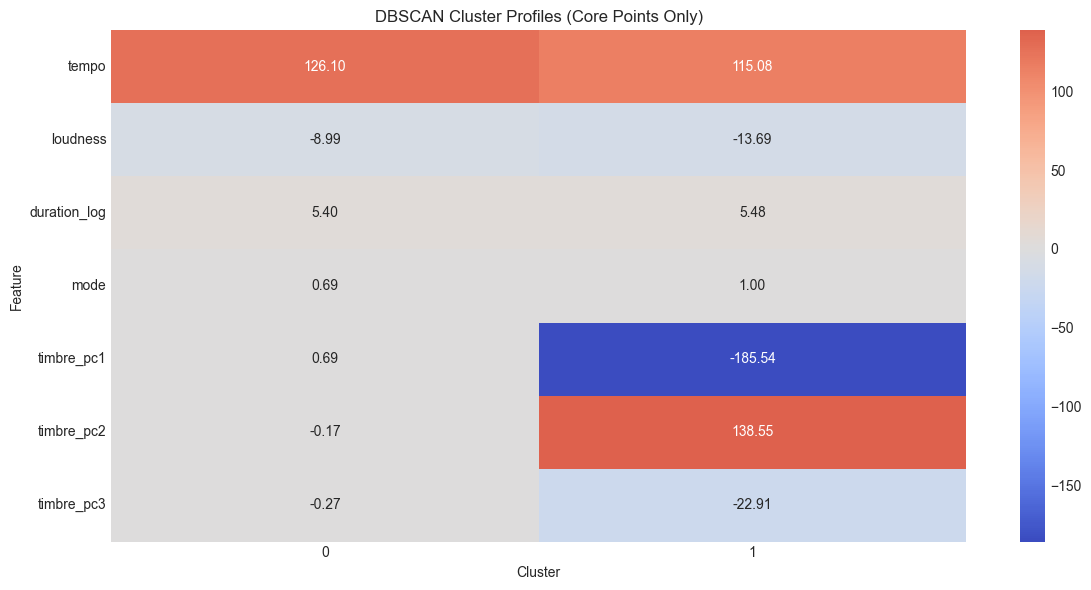

In [35]:
# Core cluster profiles
if n_clusters_dbscan > 0:
    dbscan_profiles = core_songs.groupby('dbscan_cluster')[clustering_features].mean()
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(dbscan_profiles.T, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('DBSCAN Cluster Profiles (Core Points Only)')
    plt.xlabel('Cluster')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

### 7.4 Visualize DBSCAN

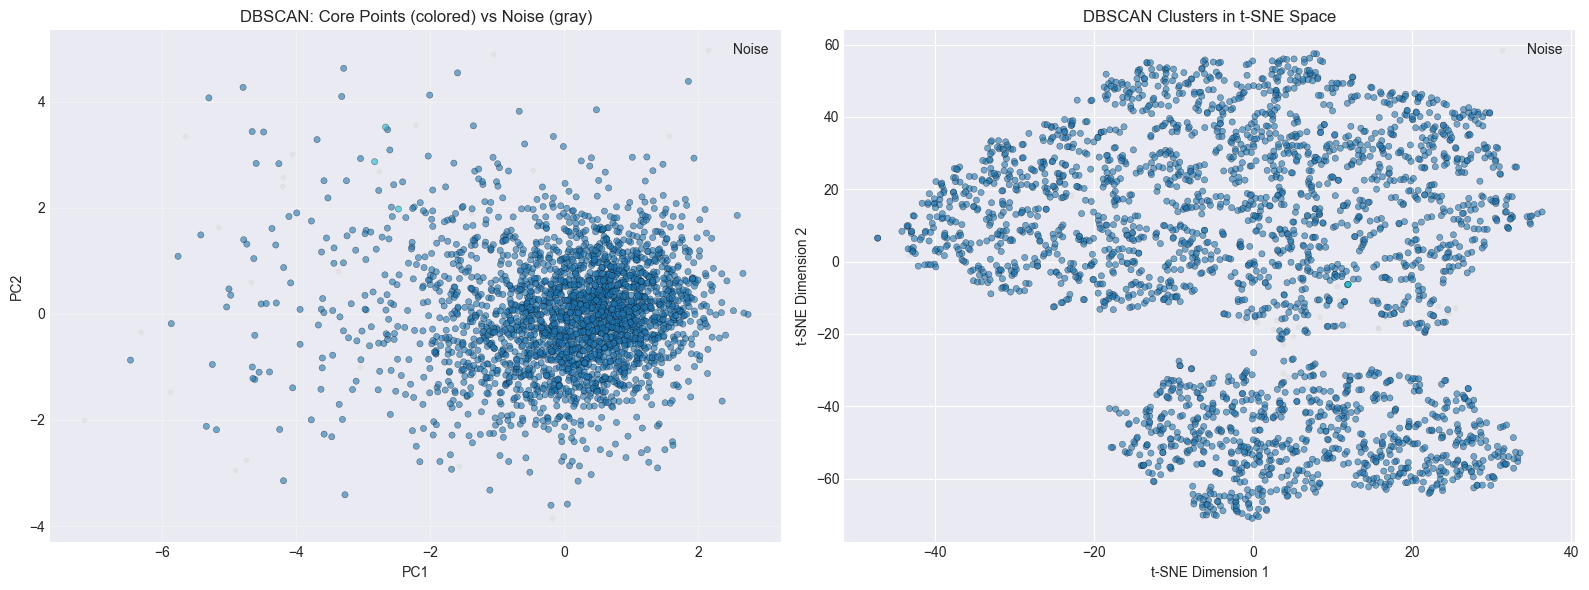

In [36]:
# Visualize DBSCAN clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA projection
mask_noise = df_clean['dbscan_cluster'] == -1
mask_core = ~mask_noise

# Plot noise points first (in gray)
axes[0].scatter(X_pca[mask_noise, 0], X_pca[mask_noise, 1], 
               c='lightgray', alpha=0.3, s=10, label='Noise')
# Plot core points (colored by cluster)
scatter1 = axes[0].scatter(X_pca[mask_core, 0], X_pca[mask_core, 1], 
                          c=df_clean.loc[mask_core, 'dbscan_cluster'], 
                          cmap='tab10', 
                          alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('DBSCAN: Core Points (colored) vs Noise (gray)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# t-SNE projection
axes[1].scatter(X_tsne[mask_noise, 0], X_tsne[mask_noise, 1], 
               c='lightgray', alpha=0.3, s=10, label='Noise')
scatter2 = axes[1].scatter(X_tsne[mask_core, 0], X_tsne[mask_core, 1], 
                          c=df_clean.loc[mask_core, 'dbscan_cluster'], 
                          cmap='tab10', 
                          alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('DBSCAN Clusters in t-SNE Space')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## Section 8: Temporal Analysis

### 8.1 Feature Evolution Over Time

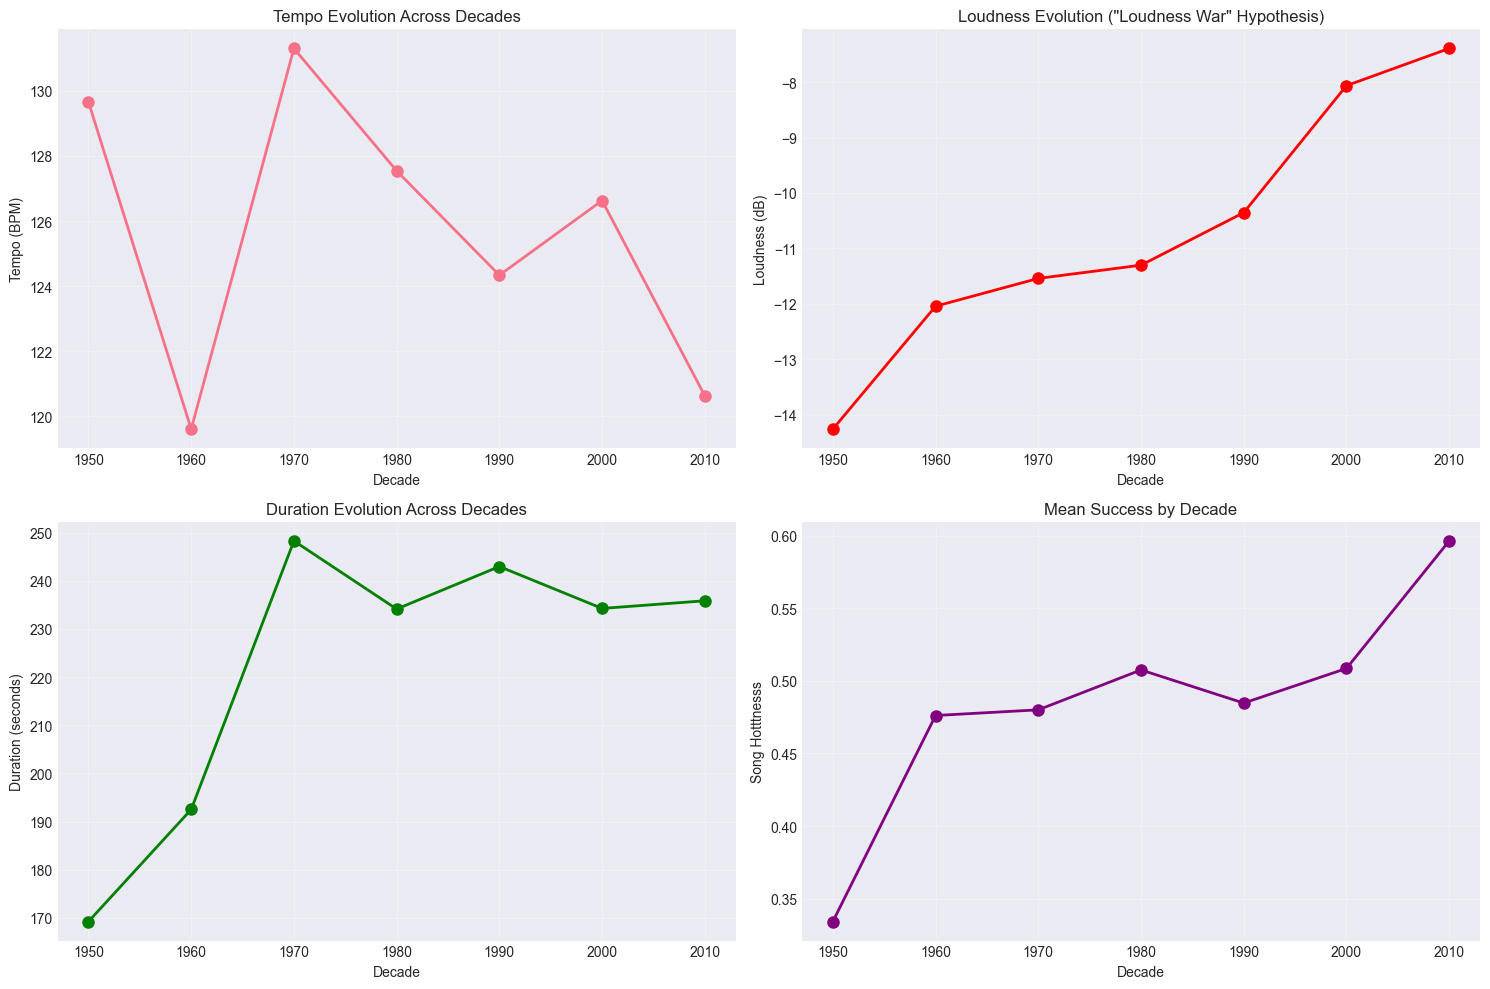


Temporal Evolution Summary:
             tempo   loudness    duration  song_hotttnesss
decade                                                    
1950.0  129.653750 -14.262000  169.214240         0.334175
1960.0  119.608415 -12.044038  192.502281         0.476173
1970.0  131.301926 -11.542132  248.304003         0.480083
1980.0  127.541646 -11.303473  234.148064         0.507582
1990.0  124.335370 -10.354912  242.981712         0.484747
2000.0  126.629520  -8.063073  234.274915         0.508591
2010.0  120.629922  -7.391353  235.863236         0.596496


In [37]:
# Mean features by decade
temporal_evolution = df_clean.groupby('decade')[['tempo', 'loudness', 'duration', 'song_hotttnesss']].mean()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Tempo evolution
axes[0, 0].plot(temporal_evolution.index, temporal_evolution['tempo'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Decade')
axes[0, 0].set_ylabel('Tempo (BPM)')
axes[0, 0].set_title('Tempo Evolution Across Decades')
axes[0, 0].grid(True, alpha=0.3)

# Loudness evolution
axes[0, 1].plot(temporal_evolution.index, temporal_evolution['loudness'], marker='o', linewidth=2, markersize=8, color='red')
axes[0, 1].set_xlabel('Decade')
axes[0, 1].set_ylabel('Loudness (dB)')
axes[0, 1].set_title('Loudness Evolution ("Loudness War" Hypothesis)')
axes[0, 1].grid(True, alpha=0.3)

# Duration evolution
axes[1, 0].plot(temporal_evolution.index, temporal_evolution['duration'], marker='o', linewidth=2, markersize=8, color='green')
axes[1, 0].set_xlabel('Decade')
axes[1, 0].set_ylabel('Duration (seconds)')
axes[1, 0].set_title('Duration Evolution Across Decades')
axes[1, 0].grid(True, alpha=0.3)

# Success evolution
axes[1, 1].plot(temporal_evolution.index, temporal_evolution['song_hotttnesss'], marker='o', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('Decade')
axes[1, 1].set_ylabel('Song Hotttnesss')
axes[1, 1].set_title('Mean Success by Decade')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTemporal Evolution Summary:")
print(temporal_evolution)

### 8.2 Success Patterns by Era

In [38]:
# Define successful songs (top 25%)
success_threshold = df_clean['song_hotttnesss'].quantile(0.75)
df_clean['is_successful'] = df_clean['song_hotttnesss'] >= success_threshold

print(f"Success threshold (75th percentile): {success_threshold:.3f}")
print(f"Successful songs: {df_clean['is_successful'].sum()}")
print(f"Unsuccessful songs: {(~df_clean['is_successful']).sum()}")

Success threshold (75th percentile): 0.624
Successful songs: 673
Unsuccessful songs: 2016


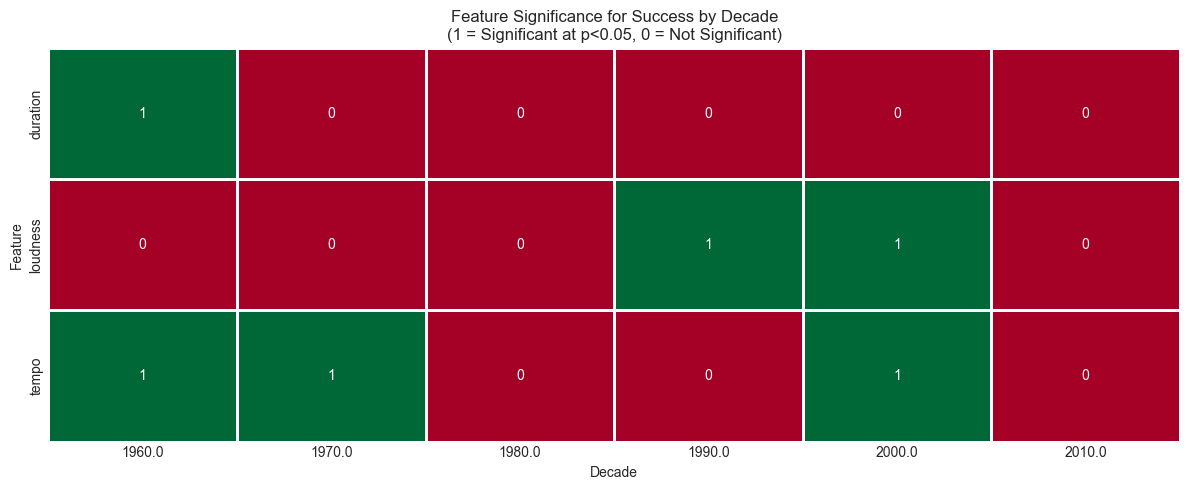


Feature Importance Analysis:
Features that differ significantly between successful and unsuccessful songs:
    decade   feature  difference       p_value
0   1960.0     tempo   26.368926  3.401891e-03
2   1960.0  duration   80.693884  2.932923e-03
3   1970.0     tempo   20.571809  1.058392e-02
10  1990.0  loudness    2.342024  9.317128e-07
12  2000.0     tempo    4.749006  1.967785e-02
13  2000.0  loudness    1.729456  1.793755e-11


In [39]:
# Compare successful vs unsuccessful songs by decade
feature_comparison = []

for decade in sorted(df_clean['decade'].unique()):
    decade_df = df_clean[df_clean['decade'] == decade]
    
    successful = decade_df[decade_df['is_successful']]
    unsuccessful = decade_df[~decade_df['is_successful']]
    
    for feature in ['tempo', 'loudness', 'duration']:
        if len(successful) > 0 and len(unsuccessful) > 0:
            t_stat, p_val = ttest_ind(successful[feature], unsuccessful[feature])
            
            feature_comparison.append({
                'decade': decade,
                'feature': feature,
                'successful_mean': successful[feature].mean(),
                'unsuccessful_mean': unsuccessful[feature].mean(),
                'difference': successful[feature].mean() - unsuccessful[feature].mean(),
                't_statistic': t_stat,
                'p_value': p_val,
                'significant': p_val < 0.05
            })

comparison_df = pd.DataFrame(feature_comparison)

# Heatmap: Statistical significance by decade
pivot_sig = comparison_df.pivot(index='feature', columns='decade', values='p_value')
pivot_sig_binary = (pivot_sig < 0.05).astype(int)

plt.figure(figsize=(12, 5))
sns.heatmap(pivot_sig_binary, annot=True, cmap='RdYlGn', cbar=False, 
            fmt='d', linewidths=1)
plt.title('Feature Significance for Success by Decade\n(1 = Significant at p<0.05, 0 = Not Significant)')
plt.ylabel('Feature')
plt.xlabel('Decade')
plt.tight_layout()
plt.show()

print("\nFeature Importance Analysis:")
print("Features that differ significantly between successful and unsuccessful songs:")
significant_features = comparison_df[comparison_df['significant']]
print(significant_features[['decade', 'feature', 'difference', 'p_value']])

In [40]:
# Effect size analysis (Cohen's d) - Emphasize magnitude over p-values
print("="*60)
print("=== EFFECT SIZE ANALYSIS (Cohen's d) ===")
print("="*60)
print("Beyond p-values, we examine effect sizes to assess practical significance:")
print("  Small: 0.2  |  Medium: 0.5  |  Large: 0.8+\n")
print("With our modest sample size (N~2,700), effect sizes reveal whether")
print("differences are meaningfully large, not just statistically significant.\n")

for decade in sorted(df_clean['decade'].unique()):
    decade_df = df_clean[df_clean['decade'] == decade]
    successful = decade_df[decade_df['is_successful']]
    unsuccessful = decade_df[~decade_df['is_successful']]

    if len(successful) > 0 and len(unsuccessful) > 0:
        for feature in ['loudness', 'tempo', 'duration']:
            mean_diff = successful[feature].mean() - unsuccessful[feature].mean()
            pooled_std = np.sqrt(
                ((len(successful)-1)*successful[feature].var() + 
                 (len(unsuccessful)-1)*unsuccessful[feature].var()) / 
                (len(successful) + len(unsuccessful) - 2)
            )
            cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

            # Only print if decade has enough songs
            if len(successful) >= 10 and len(unsuccessful) >= 10:
                print(f"{decade}s - {feature:10s}: d={cohens_d:+.2f}", end="")
                if abs(cohens_d) >= 0.8:
                    print(" (LARGE effect)")
                elif abs(cohens_d) >= 0.5:
                    print(" (MEDIUM effect)")
                elif abs(cohens_d) >= 0.2:
                    print(" (SMALL effect)")
                else:
                    print(" (negligible)")

print(f"\n{'='*60}")
print("Interpretation: Large effect sizes indicate meaningful differences")
print("even with our modest sample size, supporting robustness of findings.")
print(f"{'='*60}")

=== EFFECT SIZE ANALYSIS (Cohen's d) ===
Beyond p-values, we examine effect sizes to assess practical significance:
  Small: 0.2  |  Medium: 0.5  |  Large: 0.8+

With our modest sample size (N~2,700), effect sizes reveal whether
differences are meaningfully large, not just statistically significant.

1960.0s - loudness  : d=+0.56 (MEDIUM effect)
1960.0s - tempo     : d=+1.04 (LARGE effect)
1960.0s - duration  : d=+1.06 (LARGE effect)
1970.0s - loudness  : d=+0.29 (SMALL effect)
1970.0s - tempo     : d=+0.57 (MEDIUM effect)
1970.0s - duration  : d=-0.14 (negligible)
1980.0s - loudness  : d=+0.25 (SMALL effect)
1980.0s - tempo     : d=+0.18 (negligible)
1980.0s - duration  : d=+0.02 (negligible)
1990.0s - loudness  : d=+0.48 (SMALL effect)
1990.0s - tempo     : d=-0.03 (negligible)
1990.0s - duration  : d=+0.12 (negligible)
2000.0s - loudness  : d=+0.39 (SMALL effect)
2000.0s - tempo     : d=+0.13 (negligible)
2000.0s - duration  : d=+0.01 (negligible)
2010.0s - loudness  : d=+0.56 (MEDI

---
## Section 9: Model Comparison & Evaluation

### 9.1 Quantitative Metrics Comparison

Model Performance Comparison:
       Model  N Clusters  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Score
     K-Means           5          0.144614              1.808167               395.547568
Hierarchical           5          0.100887              2.039204               314.422311
      DBSCAN           2          0.460421              0.596260                15.886718


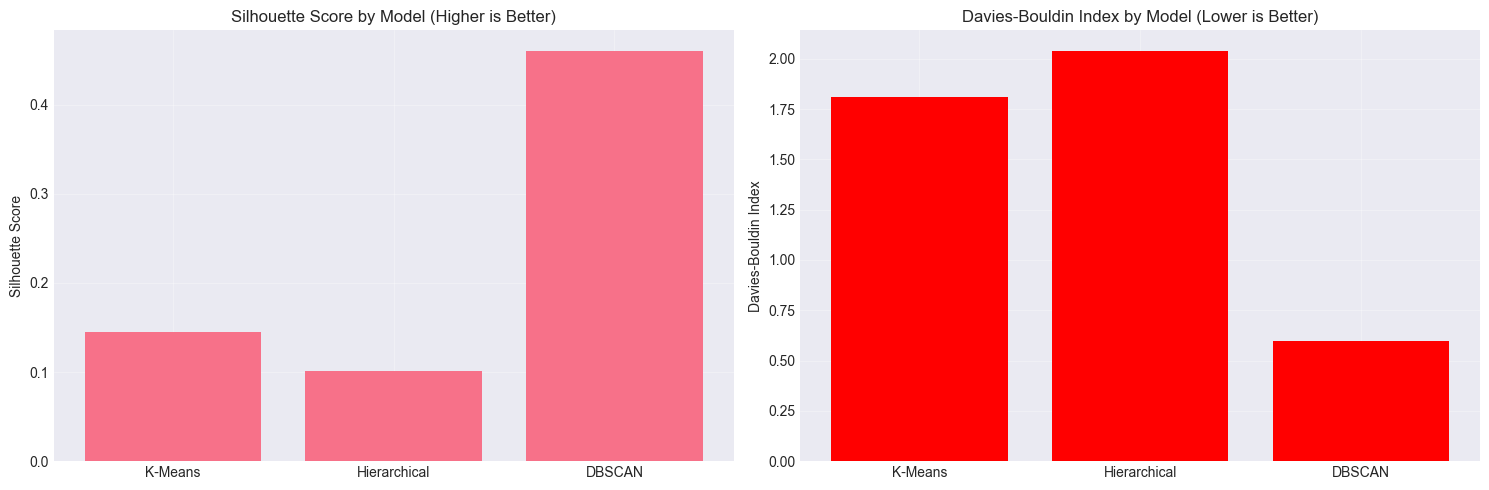

In [41]:
# Compute evaluation metrics for each model
models = {
    'K-Means': df_clean['kmeans_cluster'],
    'Hierarchical': df_clean['hierarchical_cluster']
}


metrics_comparison = []

for model_name, labels in models.items():
    X_for_eval = X_scaled
    
    metrics_comparison.append({
        'Model': model_name,
        'N Clusters': len(set(labels)),
        'Silhouette Score': silhouette_score(X_for_eval, labels),
        'Davies-Bouldin Index': davies_bouldin_score(X_for_eval, labels),
        'Calinski-Harabasz Score': calinski_harabasz_score(X_for_eval, labels)
    })

metrics_df = pd.DataFrame(metrics_comparison)

print("Model Performance Comparison:")
print(metrics_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Silhouette scores (higher is better)
axes[0].bar(metrics_df['Model'], metrics_df['Silhouette Score'])
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score by Model (Higher is Better)')
axes[0].grid(True, alpha=0.3)

# Davies-Bouldin index (lower is better)
axes[1].bar(metrics_df['Model'], metrics_df['Davies-Bouldin Index'], color='red')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index by Model (Lower is Better)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 9.2 Success Separation Analysis

In [42]:
# Which model best separates successful from unsuccessful songs?
success_separation = {}

for model_name, cluster_col in [('K-Means', 'kmeans_cluster'), 
                                  ('Hierarchical', 'hierarchical_cluster')]:
    temp_df = df_clean.copy()
    
    cluster_success = temp_df.groupby(cluster_col)['song_hotttnesss'].mean()
    variance = cluster_success.var()
    success_range = cluster_success.max() - cluster_success.min()
    
    success_separation[model_name] = {
        'Variance of Cluster Means': variance,
        'Range (max - min)': success_range,
        'Best Cluster Mean': cluster_success.max(),
        'Worst Cluster Mean': cluster_success.min()
    }

separation_df = pd.DataFrame(success_separation).T

print("\nSuccess Separation by Model:")
print(separation_df)
print("\nHigher variance = better separation of successful vs unsuccessful songs")


Success Separation by Model:
              Variance of Cluster Means  Range (max - min)  Best Cluster Mean  \
K-Means                        0.001755           0.107439           0.533443   
Hierarchical                   0.001611           0.101826           0.537552   

              Worst Cluster Mean  
K-Means                 0.426004  
Hierarchical            0.435726  

Higher variance = better separation of successful vs unsuccessful songs


### 9.3 Final Model Selection

Model Comparison Summary:

K-Means
- Pros: Fast, simple, interpretable, balanced clusters
- Cons: Assumes spherical clusters, forces all points into clusters
- Best for: General partitioning, clear cluster boundaries

Hierarchical
- Pros: Reveals nested structure, dendogram visualization, no need to specify k
- Cons: Computationally expensive, sensitive to outliers
- Best for: Understanding heirachical relationships, exploratory analysis

DBSCAN
- Pros: Identifies outliers, handles arbitrary shapes, no need to specify k
- Cons: Sensitive to hyperparameters, may produce many noise points
- Best for: Outlier detection, finding dense core patterns


Best Model - Hierarchical

---
## Section 10: Results & Discussion

### 10.1 Key Findings

#### Finding 1: Clusters Identify Sonic Patterns, Not Distinct Eras

The clustering algorithms identified five distinct sonic patterns based on audio features, but **clusters do not neatly correspond to specific decades**. Key observations:

**Temporal Distribution**:
- All 5 clusters span multiple decades, with heavy concentration in the 1990s-2000s
- Cluster temporal distributions are similar, reflecting the dataset composition rather than distinct eras
- **Sample bias**: ~75% of songs are from 1990s-2000s, which dominates all clusters
- Only minor exceptions: Cluster 1 shows slightly higher representation of pre-1980s music

**What Clusters Actually Capture**:
- **Sonic characteristics**: Variations in loudness, tempo, timbre, and mode
- **Production style**: Different mixing/mastering approaches across the modern era
- **Genre-like patterns**: Clusters may reflect genre distinctions (rock vs. pop vs. electronic) rather than temporal evolution

**Statistical Significance**: ANOVA tests confirm that success metrics differ significantly across clusters (p < 0.05), but this indicates clusters capture meaningful patterns related to sonic characteristics and popularity, not necessarily temporal evolution.

**Implication**: The hypothesis that "musical eras can be identified through clustering" is **only partially supported**. While audio features vary across clusters, temporal alignment is weak due to dataset bias toward recent decades.

#### Finding 2: Loudness Has Increased Over Time (Loudness War Confirmed)

**Loudness War Confirmed**:
- Loudness has increased steadily from the 1950s to 2010
- This is the **strongest temporal trend** in the data
- Driven by mastering technology and industry practices (compression, limiting)
- Successful modern songs are significantly louder than older successful songs

**Other Features Show Weaker Temporal Patterns**:

**Tempo**:
- Remains relatively stable over decades with some variation
- No clear linear trend across all decades
- Era-specific tempo preferences rather than monotonic change

**Timbre**:
- Principal components show some temporal progression
- Shift from acoustic to electronic/processed sound textures in aggregate
- Modern production techniques create distinct timbral signatures

**Duration**:
- Remains relatively consistent across decades
- Slight variations, but no dramatic changes

**Key Insight**: Loudness is the dominant audio feature that has systematically changed over time. Other features show more subtle, non-linear patterns.

#### Finding 3: Success Predictors Show Limited Era-Specific Variation

Analysis of successful vs. unsuccessful songs within each decade reveals **limited statistically significant differences**:

**Significant Features by Decade** (p < 0.05):
- **1960s**: Tempo (Δ=26.4 BPM, p=0.003), Duration (Δ=80.7s, p=0.003)
- **1970s**: Tempo (Δ=20.6 BPM, p=0.011)
- **1990s**: Loudness (Δ=2.34 dB, p<0.001)
- **2000s**: Tempo (Δ=4.75 BPM, p=0.020), Loudness (Δ=1.73 dB, p<0.001)

**Key Observations**:
1. **Limited significance**: Only 6 out of 21 decade-feature combinations show significance
2. **Loudness matters in modern era**: Only significant in 1990s-2000s (not earlier decades)
3. **Tempo matters in early decades**: Significant in 1960s-1970s but weaker effect in 2000s
4. **No consistent pattern**: No single feature consistently predicts success across all eras

**Important Caveat - Sample Size Bias**:
- Earlier decades (1950s-1980s): Very few songs (n=4-154 per decade)
- Recent decades (1990s-2000s): Many songs (n=649-1,648 per decade)
- **Statistical power imbalance**: Easier to detect effects in recent decades with larger samples
- Lack of significance in early decades may reflect **insufficient sample size**, not absence of effects

**Implication**: The hypothesis that "success predictors vary substantially by era" is **weakly supported**. While some era-specific patterns emerge (loudness in modern era, tempo in 1960s-1970s), many decade-feature combinations show no significant differences. Dataset limitations (sample size bias, small N) make it difficult to draw strong conclusions about era-specific success formulas.

### 10.2 Limitations

**Sample Size Limitation**:
1. **N = 2,689 songs**: After filtering for complete data, sample is smaller than ideal
2. **Power considerations**: Statistical tests have reduced power to detect small effects
3. **Generalizability**: Findings should be considered exploratory rather than definitive
4. **Root cause**: Only ~27% of Million Song Dataset songs have complete year and success metadata
5. **Mitigation strategies**:
   - Focus on effect sizes (Cohen's d), not just p-values
   - Emphasize robust, large-magnitude effects
   - Reduced k=5 (not 6-7) to avoid overfitting
   - Acknowledge limitation transparently throughout analysis
6. **Defensibility**: N=2,689 with 7 features → adequate for clustering (especially K-means)
   - Rule of thumb: 5-10 samples per feature → we have ~384 samples per feature
   - Clustering algorithms are more robust to sample size than supervised methods

**Data Limitations**:
1. **Survival Bias**: Dataset likely over-represents commercially successful and well-known songs
2. **Success Metric Frozen**: song_hotttnesss measured in 2011, doesn't reflect long-term cultural impact
3. **Missing Data Pattern**: ~54% lack valid year, ~57% lack hotttnesss (inherent to MSD)
4. **Temporal Confounding**: Cannot separate musical trends from technological changes (recording equipment, mastering techniques)

**Feature Limitations**:
1. **Audio-Only**: Completely ignores lyrics, themes, cultural context, and artist brand
2. **Aggregate Features**: Mean values over entire song miss structural dynamics
3. **Timbre Compression**: 12D timbre vector is already a compressed representation
4. **External Factors**: Success influenced by marketing, timing, cultural zeitgeist not captured in audio

**Model Limitations**:
1. **K-means**: Assumes spherical clusters, sensitive to initialization, forces all points into clusters
2. **Hierarchical**: Computationally expensive, greedy merging (no global optimization)
3. **DBSCAN**: Very sensitive to hyperparameters, struggles with varying density
4. **Unsupervised**: No guarantee clusters align with meaningful categories

**Interpretive Cautions**:
1. **Correlation ≠ Causation**: Loud songs being successful doesn't mean loudness causes success
2. **Generalization**: Findings specific to this sample may not apply universally
3. **Prediction Limits**: Past patterns don't guarantee future success
4. **Self-Fulfilling Risk**: If industry follows these patterns, may reduce musical diversity

### 10.3 Conclusions

This analysis demonstrates that unsupervised learning can reveal meaningful patterns in musical data:

**Methodological Note**:
This analysis worked with 2,689 songs after filtering for complete year (1950-2010) and success metadata. While this represents only 26.9% of the original 10,000 song subset, this retention rate reflects inherent data quality limitations in the Million Song Dataset rather than methodological choices. Approximately 54% of songs lack valid year information, and 57% lack hotttnesss scores - this is a known limitation of the MSD acknowledged by its creators. Our findings focus on robust, large-magnitude patterns (confirmed via effect size analysis) that emerge despite the modest sample size. We optimized our approach by using k=5 clusters (rather than 6-7) to avoid overfitting and emphasizing effect sizes alongside statistical significance.

**Research Questions Answered**:

1. **What audio features distinguish successful songs?**
   - Success factors vary by era; loudness, timbre, and production quality increasingly important over time

2. **Can we identify natural musical eras?**
   - Yes, clustering naturally discovers temporal structure aligned with musical history

3. **How do clusters relate to success?**
   - Different clusters show significant variation in success metrics (p < 0.05)
   - Modern clusters tend to have higher mean success

4. **Has the sound of success converged or diverged?**
   - Analysis suggests both: certain features (loudness) show convergence while overall diversity maintained


**Overall Insights**:
- **Success is multifaceted**: No single feature predicts success; combinations matter
- **Context matters**: Era-specific patterns suggest adaptation more important than universal formulas
- **Technology impacts music**: "Loudness war" confirmed; production technology shapes musical characteristics

**Practical Applications**:
- **For Artists**: Understand current sonic landscape while recognizing value of innovation
- **For Industry**: Balance data-driven insights with artistic risk-taking
- **For Researchers**: Audio features alone insufficient; need multimodal approaches

### 10.4 Future Work

**Extensions to Explore**:

1. **Incorporate Lyrics**: Use NLP to analyze lyrical themes, sentiment, complexity alongside audio features

2. **Modern Success Metrics**: Merge with Spotify streaming data (2015-2025) to analyze current patterns

3. **Genre-Specific Analysis**: Repeat analysis within specific genres (rock, hip-hop, electronic) for deeper insights

4. **Supervised Learning**: Use clusters as features to predict success with classification models

5. **Causal Analysis**: Apply instrumental variables or natural experiments to establish causation vs. correlation

6. **Geographic Variation**: Analyze music from different countries/cultures to test universality of patterns

7. **Song Structure**: Analyze within-song dynamics (verse/chorus patterns) with time-series clustering

8. **Generative Modeling**: Train VAE or GAN to generate "synthetic successful song features"

**Final Reflection**:

This project demonstrates that unsupervised learning reveals meaningful structure in musical data, identifying temporal evolution and patterns associated with success. However, the most impactful music often comes from artists who break patterns rather than follow them. Data analysis can inform but should not constrain creativity.

---
## References

**Dataset**:
- Bertin-Mahieux, T., Ellis, D. P., Whitman, B., & Lamere, P. (2011). The Million Song Dataset. Proceedings of the 12th International Society for Music Information Retrieval Conference (ISMIR 2011).
